# Definitions

In [ ]:
#@title Utils { form-width: "25%" }
import matplotlib.pyplot as plt
from typing import Optional, List
from torch import Tensor
import torch
import torchvision
import PIL
from torchvision.ops.boxes import box_area
if float(torchvision.__version__[:3]) < 0.10:
    from torchvision.ops import _new_empty_tensor
    from torchvision.ops.misc import _output_size


class NestedTensor(object):
    def __init__(self, tensors, mask: Optional[Tensor]):
        self.tensors = tensors
        self.mask = mask

    def to(self, device):
        # type: (Device) -> NestedTensor # noqa
        cast_tensor = self.tensors.to(device)
        mask = self.mask
        if mask is not None:
            assert mask is not None
            cast_mask = mask.to(device)
        else:
            cast_mask = None
        return NestedTensor(cast_tensor, cast_mask)

    def decompose(self):
        return self.tensors, self.mask

    def __repr__(self):
        return str(self.tensors)

def box_xyxy_to_cxcywh(x):
    x0, y0, x1, y1 = x.unbind(-1)
    b = [(x0 + x1) / 2, (y0 + y1) / 2,
         (x1 - x0), (y1 - y0)]
    return torch.stack(b, dim=-1)

def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(-1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=-1)

# modified from torchvision to also return the union
def box_iou(boxes1, boxes2):
    area1 = box_area(boxes1)
    area2 = box_area(boxes2)

    lt = torch.max(boxes1[:, None, :2], boxes2[:, :2])  # [N,M,2]
    rb = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])  # [N,M,2]

    wh = (rb - lt).clamp(min=0)  # [N,M,2]
    inter = wh[:, :, 0] * wh[:, :, 1]  # [N,M]

    union = area1[:, None] + area2 - inter

    iou = inter / union
    return iou, union

def _max_by_axis(the_list):
    # type: (List[List[int]]) -> List[int]
    maxes = the_list[0]
    for sublist in the_list[1:]:
        for index, item in enumerate(sublist):
            maxes[index] = max(maxes[index], item)
    return maxes

def generalized_box_iou(boxes1, boxes2):
    """
    Generalized IoU from https://giou.stanford.edu/

    The boxes should be in [x0, y0, x1, y1] format

    Returns a [N, M] pairwise matrix, where N = len(boxes1)
    and M = len(boxes2)
    """
    # degenerate boxes gives inf / nan results
    # so do an early check
    assert (boxes1[:, 2:] >= boxes1[:, :2]).all()
    assert (boxes2[:, 2:] >= boxes2[:, :2]).all()
    iou, union = box_iou(boxes1, boxes2)

    lt = torch.min(boxes1[:, None, :2], boxes2[:, :2])
    rb = torch.max(boxes1[:, None, 2:], boxes2[:, 2:])

    wh = (rb - lt).clamp(min=0)  # [N,M,2]
    area = wh[:, :, 0] * wh[:, :, 1]

    return iou - (area - union) / area

def interpolate(input, size=None, scale_factor=None, mode="nearest", align_corners=None):
    # type: (Tensor, Optional[List[int]], Optional[float], str, Optional[bool]) -> Tensor
    """
    Equivalent to nn.functional.interpolate, but with support for empty batch sizes.
    This will eventually be supported natively by PyTorch, and this
    class can go away.
    """
    if float(torchvision.__version__[:3]) < 0.10:
        if input.numel() > 0:
            return torch.nn.functional.interpolate(
                input, size, scale_factor, mode, align_corners
            )

        output_shape = _output_size(2, input, size, scale_factor)
        output_shape = list(input.shape[:-2]) + list(output_shape)
        return _new_empty_tensor(input, output_shape)
    else:
        return torchvision.ops.misc.interpolate(input, size, scale_factor, mode, align_corners)

def nested_tensor_from_tensor_list(tensor_list: List[Tensor]):
    # TODO make this more general

    #return _onnx_nested_tensor_from_tensor_list(tensor_list)
    if tensor_list[0].ndim == 3:
        if torchvision._is_tracing():
            # nested_tensor_from_tensor_list() does not export well to ONNX
            # call _onnx_nested_tensor_from_tensor_list() instead
            return _onnx_nested_tensor_from_tensor_list(tensor_list)

        # TODO make it support different-sized images
        max_size = _max_by_axis([list(img.shape) for img in tensor_list])
        # min_size = tuple(min(s) for s in zip(*[img.shape for img in tensor_list]))
        batch_shape = [len(tensor_list)] + max_size
        b, c, h, w = batch_shape
        dtype = tensor_list[0].dtype
        device = tensor_list[0].device
        tensor = torch.zeros(batch_shape, dtype=dtype, device=device)
        mask = torch.ones((b, h, w), dtype=torch.bool, device=device)
        for img, pad_img, m in zip(tensor_list, tensor, mask):
            pad_img[: img.shape[0], : img.shape[1], : img.shape[2]].copy_(img)
            m[: img.shape[1], :img.shape[2]] = False
    else:
        raise ValueError('not supported')
    return NestedTensor(tensor, mask)

def masks_to_boxes(masks):
    """Compute the bounding boxes around the provided masks

    The masks should be in format [N, H, W] where N is the number of masks, (H, W) are the spatial dimensions.

    Returns a [N, 4] tensors, with the boxes in xyxy format
    """
    if masks.numel() == 0:
        return torch.zeros((0, 4), device=masks.device)

    h, w = masks.shape[-2:]

    y = torch.arange(0, h, dtype=torch.float)
    x = torch.arange(0, w, dtype=torch.float)
    y, x = torch.meshgrid(y, x)

    x_mask = (masks * x.unsqueeze(0))
    x_max = x_mask.flatten(1).max(-1)[0]
    x_min = x_mask.masked_fill(~(masks.bool()), 1e8).flatten(1).min(-1)[0]

    y_mask = (masks * y.unsqueeze(0))
    y_max = y_mask.flatten(1).max(-1)[0]
    y_min = y_mask.masked_fill(~(masks.bool()), 1e8).flatten(1).min(-1)[0]

    return torch.stack([x_min, y_min, x_max, y_max], 1)

@torch.no_grad()
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    if target.numel() == 0:
        return [torch.zeros([], device=output.device)]
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

# _onnx_nested_tensor_from_tensor_list() is an implementation of
# nested_tensor_from_tensor_list() that is supported by ONNX tracing.
@torch.jit.unused
def _onnx_nested_tensor_from_tensor_list(tensor_list: List[Tensor]) -> NestedTensor:
    max_size = []
    # print(f'tensor_list = {tensor_list}')
    # print(f'tensor_list[0] = {tensor_list[0]}')
    # print(f'tensor_list[0].dim() = {tensor_list[0].dim()}')

    for i in range(tensor_list[0].dim()):
        max_size_i = torch.max(torch.stack([img.shape[i] for img in tensor_list]).to(torch.float32)).to(torch.int64)
        max_size.append(max_size_i)
    max_size = tuple(max_size)

    # work around for
    # pad_img[: img.shape[0], : img.shape[1], : img.shape[2]].copy_(img)
    # m[: img.shape[1], :img.shape[2]] = False
    # which is not yet supported in onnx
    padded_imgs = []
    padded_masks = []
    for img in tensor_list:
        padding = [(s1 - s2) for s1, s2 in zip(max_size, tuple(img.shape))]
        padded_img = torch.nn.functional.pad(img, (0, padding[2], 0, padding[1], 0, padding[0]))
        padded_imgs.append(padded_img)

        m = torch.zeros_like(img[0], dtype=torch.int, device=img.device)
        padded_mask = torch.nn.functional.pad(m, (0, padding[2], 0, padding[1]), "constant", 1)
        padded_masks.append(padded_mask.to(torch.bool))

    tensor = torch.stack(padded_imgs)
    mask = torch.stack(padded_masks)

    return NestedTensor(tensor, mask=mask)

In [ ]:
#@title Hungarian matcher { form-width: "25%" }
from scipy.optimize import linear_sum_assignment

class HungarianMatcher(torch.nn.Module):
    """This class computes an assignment between the targets and the predictions of the network

    For efficiency reasons, the targets don't include the no_object. Because of this, in general,
    there are more predictions than targets. In this case, we do a 1-to-1 matching of the best predictions,
    while the others are un-matched (and thus treated as non-objects).
    """

    def __init__(self, cost_class: float = 1, cost_bbox: float = 1, cost_giou: float = 1):
        """Creates the matcher

        Params:
            cost_class: This is the relative weight of the classification error in the matching cost
            cost_bbox: This is the relative weight of the L1 error of the bounding box coordinates in the matching cost
            cost_giou: This is the relative weight of the giou loss of the bounding box in the matching cost
        """
        super().__init__()
        self.cost_class = cost_class
        self.cost_bbox = cost_bbox
        self.cost_giou = cost_giou
        assert cost_class != 0 or cost_bbox != 0 or cost_giou != 0, "all costs cant be 0"

    @torch.no_grad()
    def forward(self, outputs, targets):
        """ Performs the matching

        Params:
            outputs: This is a dict that contains at least these entries:
                 "pred_logits": Tensor of dim [batch_size, num_queries, num_classes] with the classification logits
                 "pred_boxes": Tensor of dim [batch_size, num_queries, 4] with the predicted box coordinates

            targets: This is a list of targets (len(targets) = batch_size), where each target is a dict containing:
                 "labels": Tensor of dim [num_target_boxes] (where num_target_boxes is the number of ground-truth
                           objects in the target) containing the class labels
                 "boxes": Tensor of dim [num_target_boxes, 4] containing the target box coordinates

        Returns:
            A list of size batch_size, containing tuples of (index_i, index_j) where:
                - index_i is the indices of the selected predictions (in order)
                - index_j is the indices of the corresponding selected targets (in order)
            For each batch element, it holds:
                len(index_i) = len(index_j) = min(num_queries, num_target_boxes)
        """
        bs, num_queries = outputs["pred_logits"].shape[:2]

        # We flatten to compute the cost matrices in a batch
        out_prob = outputs["pred_logits"].flatten(0, 1).softmax(-1)  # [batch_size * num_queries, num_classes]
        out_bbox = outputs["pred_boxes"].flatten(0, 1)  # [batch_size * num_queries, 4]

        # Also concat the target labels and boxes
        tgt_ids = torch.cat([v["labels"] for v in targets])
        tgt_bbox = torch.cat([v["boxes"] for v in targets])

        # Compute the classification cost. Contrary to the loss, we don't use the NLL,
        # but approximate it in 1 - proba[target class].
        # The 1 is a constant that doesn't change the matching, it can be ommitted.
        cost_class = -out_prob[:, tgt_ids]

        # Compute the L1 cost between boxes
        cost_bbox = torch.cdist(out_bbox, tgt_bbox, p=1)

        # Compute the giou cost betwen boxes
        cost_giou = -generalized_box_iou(box_cxcywh_to_xyxy(out_bbox), box_cxcywh_to_xyxy(tgt_bbox))

        # Final cost matrix
        C = self.cost_bbox * cost_bbox + self.cost_class * cost_class + self.cost_giou * cost_giou
        C = C.view(bs, num_queries, -1).cpu()

        sizes = [len(v["boxes"]) for v in targets]
        indices = [linear_sum_assignment(c[i]) for i, c in enumerate(C.split(sizes, -1))]
        return [(torch.as_tensor(i, dtype=torch.int64), torch.as_tensor(j, dtype=torch.int64)) for i, j in indices]

@torch.jit.export
def build_matcher(args):
    return HungarianMatcher(cost_class=args.set_cost_class, cost_bbox=args.set_cost_bbox, cost_giou=args.set_cost_giou)

In [ ]:
#@title Model - Positional Encoding   { form-width: "25%" }
import math
from torch import nn

class PositionEmbeddingSine(nn.Module):
    """
    This is a more standard version of the position embedding, very similar to the one
    used by the Attention is all you need paper, generalized to work on images.
    """
    def __init__(self, num_pos_feats=64, temperature=10000, normalize=False, scale=None):
        super().__init__()
        self.num_pos_feats = num_pos_feats
        self.temperature = temperature
        self.normalize = normalize
        if scale is not None and normalize is False:
            raise ValueError("normalize should be True if scale is passed")
        if scale is None:
            scale = 2 * math.pi
        self.scale = scale

    def forward(self, tensor_list: NestedTensor):
        x = tensor_list.tensors
        mask = tensor_list.mask
        assert mask is not None
        not_mask = ~mask
        y_embed = not_mask.cumsum(1, dtype=torch.float32)
        x_embed = not_mask.cumsum(2, dtype=torch.float32)
        if self.normalize:
            eps = 1e-6
            y_embed = y_embed / (y_embed[:, -1:, :] + eps) * self.scale
            x_embed = x_embed / (x_embed[:, :, -1:] + eps) * self.scale

        dim_t = torch.arange(self.num_pos_feats, dtype=torch.float32, device=x.device)
        dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)

        pos_x = x_embed[:, :, :, None] / dim_t
        pos_y = y_embed[:, :, :, None] / dim_t
        pos_x = torch.stack((pos_x[:, :, :, 0::2].sin(), pos_x[:, :, :, 1::2].cos()), dim=4).flatten(3)
        pos_y = torch.stack((pos_y[:, :, :, 0::2].sin(), pos_y[:, :, :, 1::2].cos()), dim=4).flatten(3)
        pos = torch.cat((pos_y, pos_x), dim=3).permute(0, 3, 1, 2)
        return pos


class PositionEmbeddingLearned(nn.Module):
    """
    Absolute pos embedding, learned.
    """
    def __init__(self, num_pos_feats=256):
        super().__init__()
        self.row_embed = nn.Embedding(50, num_pos_feats)
        self.col_embed = nn.Embedding(50, num_pos_feats)
        self.reset_parameters()

    @torch.jit.export
    def reset_parameters(self):
        nn.init.uniform_(self.row_embed.weight)
        nn.init.uniform_(self.col_embed.weight)

    def forward(self, tensor_list: NestedTensor):
        x = tensor_list.tensors
        h, w = x.shape[-2:]
        i = torch.arange(w, device=x.device)
        j = torch.arange(h, device=x.device)
        x_emb = self.col_embed(i)
        y_emb = self.row_embed(j)
        pos = torch.cat([
            x_emb.unsqueeze(0).repeat(h, 1, 1),
            y_emb.unsqueeze(1).repeat(1, w, 1),
        ], dim=-1).permute(2, 0, 1).unsqueeze(0).repeat(x.shape[0], 1, 1, 1)
        return pos

@torch.jit.export
def build_position_encoding(args):
    N_steps = args.hidden_dim // 2
    if args.position_embedding in ('v2', 'sine'):
        position_embedding = PositionEmbeddingSine(N_steps, normalize=True)
    elif args.position_embedding in ('v3', 'learned'):
        position_embedding = PositionEmbeddingLearned(N_steps)
    else:
        raise ValueError(f"not supported {args.position_embedding}")

    return position_embedding

# Model - MambaLayer

In [ ]:
#@title Model - MambaLayer   { form-width: "25%" }

from mamba_ssm import Mamba
import ptwt, pywt
class MambaLayer(nn.Module):
    def __init__(self, dim, d_state = 16, d_conv = 4, expand = 2):
        super().__init__()
        self.dim = dim
        self.norm = nn.LayerNorm(dim)
        self.mamba = Mamba(
                d_model=dim, # Model dimension d_model
                d_state=d_state,  # SSM state expansion factor
                d_conv=d_conv,    # Local convolution width
                expand=expand,    # Block expansion factor
        )

    def forward(self, x):
        if x.dtype == torch.float16:
            x = x.type(torch.float32)
        B, C = x.shape[:2]
        assert C == self.dim
        n_tokens = x.shape[2:].numel()
        img_dims = x.shape[2:]
        x_flat = x.reshape(B, C, n_tokens).transpose(-1, -2)
        x_norm = self.norm(x_flat)
        x_mamba = self.mamba(x_norm)
        x_mamba = x_flat + x_mamba
        out = x_mamba.transpose(-1, -2).reshape(B, C, *img_dims)

        return out
        
    # def forward(self, x):
    #     if x.dtype == torch.float16:
    #         x = x.type(torch.float32)
    #     B, C, H, W = x.shape
    #     # print(H,W)
    #     assert C == self.dim
    #     n_tokens = x.shape[2:].numel()
    #     img_dims = x.shape[2:]

    #     #expand the x
    #     level = pywt.dwtn_max_level((H, W), 'db2')
    #     level = 2 if level > 2 else 1

    #     expand_x = torch.zeros(B, C, H if H%2==0 else H+1, W if W%2==0 else W+1, device=torch.device('cuda'))
    #     expand_x[..., :H, :W] = x

    #     coeff = ptwt.wavedec2(expand_x, 'db2', level=level)
        
    #     #set the initial list and append 1st element
    #     flat_x = coeff[0]
    #     dim_coef = [flat_x.shape[2:]]
    #     token_coef = [flat_x.shape[2:].numel()]
    #     flat_x = flat_x.reshape(B, C, -1)

    #     for i in range(1, len(coeff)):
    #         for j in range(3):
    #             dim_coef.append(coeff[i][j].shape[2:])
    #             token_coef.append(coeff[i][j].shape[2:].numel())
    #             sub_coeff = coeff[i][j].reshape(B, C, -1)
    #             flat_x = torch.cat((flat_x, sub_coeff), axis=2)

    #     #list dict element, flatten and concatenate all elements
    #     input = flat_x.transpose(-1, -2)
        
    #     #do normalization and mamba layer
    #     x_norm = self.norm(input)
    #     x_mamba = self.mamba(x_norm)
    #     x_mamba = input + x_mamba

    #     out_x = x_mamba.transpose(-1, -2)
    #     out_x_split = list(torch.split(out_x, token_coef, dim=2))
        
    #     rec_x = [out_x_split.pop(0).reshape(B, C, dim_coef[0][0], dim_coef[0][1])]

    #     for i in range(1, len(coeff)):
    #         sub_rec_x = []
    #         for j in range(3):
    #             sub_rec_x.append(out_x_split.pop(0).reshape(B, C, dim_coef[i * 3 - 2 + j][0], dim_coef[i * 3 - 2 + j][1]))
    #         rec_x.append(tuple(sub_rec_x))

    #     rec_coeff = ptwt.waverec2(rec_x, 'db2')
    #     raw_x = rec_coeff[..., :H, :W]

    #     #reshape the output back to multiple dim coeff, inverse the wavelet and reshape to H*W*D
    #     out = raw_x.reshape(B, C, *img_dims)
    #     out = x + out

    #     return out

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DSPM(nn.Module):
    def __init__(self, in_channels, out_channels, dilation_rates=[1, 3, 6], branch_order=["pool", "d1", "d3", "d6"]):
        super(DSPM, self).__init__()
        # assert set(branch_order) == set(["pool"] + [f"d{d}" for d in dilation_rates]), "branch_order 和 dilation_rates 不符"
        self.branch_order = branch_order
        reduced_channels = out_channels // 1  # 通道先減少以省記憶體，提升穩定性

        self.conv_1x1 =  nn.Conv2d(in_channels, reduced_channels, kernel_size=1, bias=False)
        self.dilated_convs = nn.ModuleDict()
        for d in dilation_rates:
            self.dilated_convs[f"d{d}"] = nn.Sequential(
                nn.Conv2d(in_channels, reduced_channels, kernel_size=3, padding=d, dilation=d, bias=False),
            )

        # Global pooling 分支
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.global_conv = nn.Conv2d(in_channels, reduced_channels, kernel_size=1, bias=False)


        # 最後整合所有分支的 1x1 conv
        num_branches = len(dilation_rates) + 1
        self.fuse = nn.Sequential(
            # nn.Dropout(p=0.2)
            nn.Conv2d(reduced_channels * num_branches, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        branch_outputs = []

        for name in self.branch_order:
            if name == "pool":
                pool_out = self.global_pool(x)
                pool_out = self.global_conv(pool_out)
                pool_out = F.interpolate(pool_out, size=x.shape[2:], mode="bilinear", align_corners=False)
                branch_outputs.append(pool_out)

                # branch_outputs.append(self.conv_1x1(x))
            # elif name == "d1":
                # branch_outputs.append(self.conv_1x1(x))
            else:  # d3, d6...
                branch_outputs.append(self.dilated_convs[name](x))

        x = torch.cat(branch_outputs, dim=1)
        x = self.fuse(x)
        return x


# CNN Backbone

In [ ]:
#@title Model - CNN Backbone { form-width: "25%" }
from collections import OrderedDict
import torch
import torch.nn.functional as F
import torchvision
from torch import nn
from torchvision.models._utils import IntermediateLayerGetter
from typing import Dict, List

class FrozenBatchNorm2d(torch.nn.Module):
    """
    BatchNorm2d where the batch statistics and the affine parameters are fixed.

    Copy-paste from torchvision.misc.ops with added eps before rqsrt,
    without which any other models than torchvision.models.resnet[18,34,50,101]
    produce nans.
    """

    def __init__(self, n):
        super(FrozenBatchNorm2d, self).__init__()
        self.register_buffer("weight", torch.ones(n))
        self.register_buffer("bias", torch.zeros(n))
        self.register_buffer("running_mean", torch.zeros(n))
        self.register_buffer("running_var", torch.ones(n))

    @torch.jit.export
    def _load_from_state_dict(self, state_dict, prefix, local_metadata, strict,
                              missing_keys, unexpected_keys, error_msgs):
        num_batches_tracked_key = prefix + 'num_batches_tracked'
        if num_batches_tracked_key in state_dict:
            del state_dict[num_batches_tracked_key]

        super(FrozenBatchNorm2d, self)._load_from_state_dict(
            state_dict, prefix, local_metadata, strict,
            missing_keys, unexpected_keys, error_msgs)

    def forward(self, x):
        # move reshapes to the beginning
        # to make it fuser-friendly
        w = self.weight.reshape(1, -1, 1, 1)
        b = self.bias.reshape(1, -1, 1, 1)
        rv = self.running_var.reshape(1, -1, 1, 1)
        rm = self.running_mean.reshape(1, -1, 1, 1)
        eps = 1e-5
        scale = w * (rv + eps).rsqrt()
        bias = b - rm * scale
        return x * scale + bias


class BackboneBase(nn.Module):

    def __init__(self, backbone: nn.Module, train_backbone: bool, num_channels: int, return_interm_layers: bool):
        super().__init__()
        for name, parameter in backbone.named_parameters():
            if not train_backbone or 'layer2' not in name and 'layer3' not in name and 'layer4' not in name:
                parameter.requires_grad_(False)
        if return_interm_layers:
            return_layers = {"layer1": "0", "layer2": "1", "layer3": "2", "layer4": "3"}
        else:
            return_layers = {'layer4': "0"}
        self.body = IntermediateLayerGetter(backbone, return_layers=return_layers)
        self.num_channels = num_channels

    def forward(self, tensor_list: NestedTensor):
        xs = self.body(tensor_list.tensors)
        out: Dict[str, NestedTensor] = {}
        for name, x in xs.items():
            m = tensor_list.mask
            assert m is not None
            mask = F.interpolate(m[None].float(), size=x.shape[-2:]).to(torch.bool)[0]
            out[name] = NestedTensor(x, mask)
        # print(f'Okayge = {tensor_list.tensors.shape}')
        return out


class Backbone(BackboneBase):
    """ResNet backbone with frozen BatchNorm."""
    def __init__(self, name: str,
                 train_backbone: bool,
                 return_interm_layers: bool,
                 dilation: bool):
        backbone = getattr(torchvision.models, name)(
            replace_stride_with_dilation=[False, False, dilation],
            pretrained=True, norm_layer=FrozenBatchNorm2d)
        
#         original_layer4 = list(backbone.layer4.children())
#         backbone.layer4 = nn.Sequential(
#             *original_layer4,
#             MambaLayer(dim=2048)
#         )
        
        num_channels = 512 if name in ('resnet18', 'resnet34') else 2048
        super().__init__(backbone, train_backbone, num_channels, return_interm_layers)


class Joiner(nn.Sequential):
    def __init__(self, backbone, position_embedding):
        super().__init__(backbone, position_embedding)

    def forward(self, tensor_list: NestedTensor):
        xs = self[0](tensor_list)
        out: List[NestedTensor] = []
        pos = []
        for name, x in xs.items():
            out.append(x)
            # position encoding
            pos.append(self[1](x).to(x.tensors.dtype))

        return out, pos

@torch.jit.export
def build_backbone(args):
    position_embedding = build_position_encoding(args)
    train_backbone = args.lr_backbone > 0
    return_interm_layers = args.masks
    backbone = Backbone(args.backbone, train_backbone, return_interm_layers, args.dilation)
    model = Joiner(backbone, position_embedding)
    model.num_channels = backbone.num_channels
    return model

In [ ]:
def _expand(tensor, length: int):
    return tensor.unsqueeze(1).repeat(1, int(length), 1, 1, 1).flatten(0, 1)


class MaskHeadSmallConv(nn.Module):
    """
    Simple convolutional head, using group norm.
    Upsampling is done using a FPN approach
    """

    def __init__(self, dim, fpn_dims, context_dim):
        super().__init__()

        inter_dims = [dim, context_dim // 2, context_dim // 4, context_dim // 8, context_dim // 16, context_dim // 64]
        self.lay1 = torch.nn.Conv2d(dim, dim, 3, padding=1)
        self.gn1 = torch.nn.GroupNorm(8, dim)
        self.lay2 = torch.nn.Conv2d(dim, inter_dims[1], 3, padding=1)
        self.gn2 = torch.nn.GroupNorm(8, inter_dims[1])
        self.lay3 = torch.nn.Conv2d(inter_dims[1], inter_dims[2], 3, padding=1)
        self.gn3 = torch.nn.GroupNorm(8, inter_dims[2])
        self.lay4 = torch.nn.Conv2d(inter_dims[2], inter_dims[3], 3, padding=1)
        self.gn4 = torch.nn.GroupNorm(8, inter_dims[3])
        self.lay5 = torch.nn.Conv2d(inter_dims[3], inter_dims[4], 3, padding=1)
        self.gn5 = torch.nn.GroupNorm(8, inter_dims[4])
        self.out_lay = torch.nn.Conv2d(inter_dims[4], 1, 3, padding=1)

        self.dim = dim

        self.adapter1 = torch.nn.Conv2d(fpn_dims[0], inter_dims[1], 1)
        self.adapter2 = torch.nn.Conv2d(fpn_dims[1], inter_dims[2], 1)
        self.adapter3 = torch.nn.Conv2d(fpn_dims[2], inter_dims[3], 1)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_uniform_(m.weight, a=1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x: Tensor, bbox_mask: Tensor, fpns: List[Tensor]):
        x = torch.cat([_expand(x, bbox_mask.shape[1]), bbox_mask.flatten(0, 1)], 1)

        x = self.lay1(x)
        x = self.gn1(x)
        x = F.relu(x)
        x = self.lay2(x)
        x = self.gn2(x)
        x = F.relu(x)

        cur_fpn = self.adapter1(fpns[0])
        if cur_fpn.size(0) != x.size(0):
            cur_fpn = _expand(cur_fpn, x.size(0) // cur_fpn.size(0))
        x = cur_fpn + F.interpolate(x, size=cur_fpn.shape[-2:], mode="nearest")
        x = self.lay3(x)
        x = self.gn3(x)
        x = F.relu(x)

        cur_fpn = self.adapter2(fpns[1])
        if cur_fpn.size(0) != x.size(0):
            cur_fpn = _expand(cur_fpn, x.size(0) // cur_fpn.size(0))
        x = cur_fpn + F.interpolate(x, size=cur_fpn.shape[-2:], mode="nearest")
        x = self.lay4(x)
        x = self.gn4(x)
        x = F.relu(x)

        cur_fpn = self.adapter3(fpns[2])
        if cur_fpn.size(0) != x.size(0):
            cur_fpn = _expand(cur_fpn, x.size(0) // cur_fpn.size(0))
        x = cur_fpn + F.interpolate(x, size=cur_fpn.shape[-2:], mode="nearest")
        x = self.lay5(x)
        x = self.gn5(x)
        x = F.relu(x)

        x = self.out_lay(x)
        return x

In [ ]:
#@title Model - Segmentation { form-width: "25%" }
"""
This file provides the definition of the convolutional heads used to predict masks, as well as the losses
"""
import io
from collections import defaultdict

import torch.nn.functional as F
from torch import Tensor
from PIL import Image

try:
    from panopticapi.utils import id2rgb, rgb2id
except ImportError:
    pass

class DETRsegm(nn.Module):
    def __init__(self, detr, freeze_detr=False):
        super().__init__()
        self.detr = detr

        if freeze_detr:
            for p in self.parameters():
                p.requires_grad_(False)

        hidden_dim, nheads = detr.transformer.d_model, detr.transformer.nhead
        self.bbox_attention = MHAttentionMap(hidden_dim, hidden_dim, nheads, dropout=0.0)
        self.mask_head = MaskHeadSmallConv(hidden_dim + nheads, [1024, 512, 256], hidden_dim)

    def forward(self, samples: NestedTensor):
        if isinstance(samples, (list, torch.Tensor)):
            samples = nested_tensor_from_tensor_list(samples)
        features, pos = self.detr.backbone(samples)

        bs = features[-1].tensors.shape[0]

        src, mask = features[-1].decompose()
        assert mask is not None
        src_proj = self.detr.input_proj(src)
        hs, memory = self.detr.transformer(src_proj, mask, self.detr.query_embed.weight, pos[-1])

        outputs_class = self.detr.class_embed(hs)
        outputs_coord = self.detr.bbox_embed(hs).sigmoid()
        out = {"pred_logits": outputs_class[-1], "pred_boxes": outputs_coord[-1]}
        if self.detr.aux_loss:
            out['aux_outputs'] = self.detr._set_aux_loss(outputs_class, outputs_coord)
        #tag1.1
        # FIXME h_boxes takes the last one computed, keep this in mind
        bbox_mask = self.bbox_attention(hs[-1], memory, mask=mask)

        seg_masks = self.mask_head(src_proj, bbox_mask, [features[2].tensors, features[1].tensors, features[0].tensors])
        outputs_seg_masks = seg_masks.view(bs, self.detr.num_queries, seg_masks.shape[-2], seg_masks.shape[-1])

        out["pred_masks"] = outputs_seg_masks
        return out

# class DETRsegm(nn.Module):
#     def __init__(self, detr, freeze_detr=False):
#         super().__init__()
#         self.detr = detr

#         if freeze_detr:
#             for p in self.parameters():
#                 p.requires_grad_(False)

#         hidden_dim, nheads = detr.transformer.d_model, detr.transformer.nhead
#         self.bbox_attention = MHAttentionMap(hidden_dim, hidden_dim, nheads, dropout=0.0)
#         self.mask_head = MaskHeadSmallConv(hidden_dim + nheads, [1024, 512, 256], hidden_dim)

#         self.fuse_mode='concat'
#         hidden_dim = self.detr.transformer.d_model
#         # mid_dim = self.detr.backbone.num_channels[-2]  # e.g., 1024 from C4
#         mid_dim = 1024

#         if self.fuse_mode == 'add':
#             self.input_proj_mid = nn.Conv2d(mid_dim, hidden_dim, kernel_size=1)
#         elif self.fuse_mode == 'concat':
#             self.input_proj_mid = nn.Conv2d(mid_dim, hidden_dim, kernel_size=1)
#             self.input_proj_fuse = nn.Conv2d(hidden_dim * 2, hidden_dim, kernel_size=1)
#         else:
#             raise ValueError(f"Unsupported fuse_mode: {self.fuse_mode}")

#     def forward(self, samples: NestedTensor):
#         if isinstance(samples, (list, torch.Tensor)):
#             samples = nested_tensor_from_tensor_list(samples)
#         features, pos = self.detr.backbone(samples)


#         feat_high, mask_high = features[-1].decompose()  # C5
#         feat_mid, mask_mid  = features[-2].decompose()  # C4

#         proj_mid = self.input_proj_mid(feat_mid)
#         proj_mid_upsampled = F.interpolate(proj_mid, size=feat_high.shape[-2:], mode='bilinear', align_corners=False)

#         proj_high = self.detr.input_proj(feat_high)

#         if self.fuse_mode == 'add':
#             src_proj = proj_high + proj_mid_upsampled
#         elif self.fuse_mode == 'concat':
#             fused = torch.cat([proj_high, proj_mid_upsampled], dim=1)
#             src_proj = self.input_proj_fuse(fused)

#         bs = features[-1].tensors.shape[0]
#         src, mask = features[-1].decompose()
#         assert mask is not None
#         # src_proj = self.detr.input_proj(src)
#         hs, memory = self.detr.transformer(src_proj, mask, self.detr.query_embed.weight, pos[-1])

#         outputs_class = self.detr.class_embed(hs)
#         outputs_coord = self.detr.bbox_embed(hs).sigmoid()
#         out = {"pred_logits": outputs_class[-1], "pred_boxes": outputs_coord[-1]}
#         if self.detr.aux_loss:
#             out['aux_outputs'] = self.detr._set_aux_loss(outputs_class, outputs_coord)
#         #tag1.1
#         # FIXME h_boxes takes the last one computed, keep this in mind
#         bbox_mask = self.bbox_attention(hs[-1], memory, mask=mask)

#         seg_masks = self.mask_head(src_proj, bbox_mask, [features[2].tensors, features[1].tensors, features[0].tensors])
#         outputs_seg_masks = seg_masks.view(bs, self.detr.num_queries, seg_masks.shape[-2], seg_masks.shape[-1])

#         out["pred_masks"] = outputs_seg_masks
#         return out

@torch.jit.export
def _expand(tensor, length: int):
    return tensor.unsqueeze(1).repeat(1, int(length), 1, 1, 1).flatten(0, 1)


class MaskHeadSmallConv(nn.Module):
    """
    Simple convolutional head, using group norm.
    Upsampling is done using a FPN approach
    """

    def __init__(self, dim, fpn_dims, context_dim):
        super().__init__()

        inter_dims = [dim, context_dim // 2, context_dim // 4, context_dim // 8, context_dim // 16, context_dim // 64]
        self.lay1 = torch.nn.Conv2d(dim, dim, 3, padding=1)
        self.gn1 = torch.nn.GroupNorm(8, dim)
        self.lay2 = torch.nn.Conv2d(dim, inter_dims[1], 3, padding=1)
        self.gn2 = torch.nn.GroupNorm(8, inter_dims[1])
        self.lay3 = torch.nn.Conv2d(inter_dims[1], inter_dims[2], 3, padding=1)
        self.gn3 = torch.nn.GroupNorm(8, inter_dims[2])
        self.lay4 = torch.nn.Conv2d(inter_dims[2], inter_dims[3], 3, padding=1)
        self.gn4 = torch.nn.GroupNorm(8, inter_dims[3])
        self.lay5 = torch.nn.Conv2d(inter_dims[3], inter_dims[4], 3, padding=1)
        self.gn5 = torch.nn.GroupNorm(8, inter_dims[4])
        self.out_lay = torch.nn.Conv2d(inter_dims[4], 1, 3, padding=1)

        self.dim = dim

        self.adapter1 = torch.nn.Conv2d(fpn_dims[0], inter_dims[1], 1)
        self.adapter2 = torch.nn.Conv2d(fpn_dims[1], inter_dims[2], 1)
        self.adapter3 = torch.nn.Conv2d(fpn_dims[2], inter_dims[3], 1)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_uniform_(m.weight, a=1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x: Tensor, bbox_mask: Tensor, fpns: List[Tensor]):
        x = torch.cat([_expand(x, bbox_mask.shape[1]), bbox_mask.flatten(0, 1)], 1)

        x = self.lay1(x)
        x = self.gn1(x)
        x = F.relu(x)
        x = self.lay2(x)
        x = self.gn2(x)
        x = F.relu(x)

        cur_fpn = self.adapter1(fpns[0])
        if cur_fpn.size(0) != x.size(0):
            cur_fpn = _expand(cur_fpn, x.size(0) // cur_fpn.size(0))
        x = cur_fpn + F.interpolate(x, size=cur_fpn.shape[-2:], mode="nearest")
        x = self.lay3(x)
        x = self.gn3(x)
        x = F.relu(x)

        cur_fpn = self.adapter2(fpns[1])
        if cur_fpn.size(0) != x.size(0):
            cur_fpn = _expand(cur_fpn, x.size(0) // cur_fpn.size(0))
        x = cur_fpn + F.interpolate(x, size=cur_fpn.shape[-2:], mode="nearest")
        x = self.lay4(x)
        x = self.gn4(x)
        x = F.relu(x)

        cur_fpn = self.adapter3(fpns[2])
        if cur_fpn.size(0) != x.size(0):
            cur_fpn = _expand(cur_fpn, x.size(0) // cur_fpn.size(0))
        x = cur_fpn + F.interpolate(x, size=cur_fpn.shape[-2:], mode="nearest")
        x = self.lay5(x)
        x = self.gn5(x)
        x = F.relu(x)

        x = self.out_lay(x)
        return x


class MHAttentionMap(nn.Module):
    """This is a 2D attention module, which only returns the attention softmax (no multiplication by value)"""

    def __init__(self, query_dim, hidden_dim, num_heads, dropout=0.0, bias=True):
        super().__init__()
        self.num_heads = num_heads
        self.hidden_dim = hidden_dim
        self.dropout = nn.Dropout(dropout)

        self.q_linear = nn.Linear(query_dim, hidden_dim, bias=bias)
        self.k_linear = nn.Linear(query_dim, hidden_dim, bias=bias)

        nn.init.zeros_(self.k_linear.bias)
        nn.init.zeros_(self.q_linear.bias)
        nn.init.xavier_uniform_(self.k_linear.weight)
        nn.init.xavier_uniform_(self.q_linear.weight)
        self.normalize_fact = float(hidden_dim / self.num_heads) ** -0.5

    def forward(self, q, k, mask: Optional[Tensor] = None):
        q = self.q_linear(q)
        k = F.conv2d(k, self.k_linear.weight.unsqueeze(-1).unsqueeze(-1), self.k_linear.bias)
        qh = q.view(q.shape[0], q.shape[1], self.num_heads, self.hidden_dim // self.num_heads)
        kh = k.view(k.shape[0], self.num_heads, self.hidden_dim // self.num_heads, k.shape[-2], k.shape[-1])
        weights = torch.einsum("bqnc,bnchw->bqnhw", qh * self.normalize_fact, kh)

        if mask is not None:
            weights.masked_fill_(mask.unsqueeze(1).unsqueeze(1), float("-inf"))
        weights = F.softmax(weights.flatten(2), dim=-1).view(weights.size())
        weights = self.dropout(weights)
        return weights

@torch.jit.export
def dice_loss(inputs, targets, num_boxes):
    """
    Compute the DICE loss, similar to generalized IOU for masks
    Args:
        inputs: A float tensor of arbitrary shape.
                The predictions for each example.
        targets: A float tensor with the same shape as inputs. Stores the binary
                 classification label for each element in inputs
                (0 for the negative class and 1 for the positive class).
    """
    inputs = inputs.sigmoid()
    inputs = inputs.flatten(1)
    numerator = 2 * (inputs * targets).sum(1)
    denominator = inputs.sum(-1) + targets.sum(-1)
    loss = 1 - (numerator + 1) / (denominator + 1)
    return loss.sum() / num_boxes

@torch.jit.export
def sigmoid_focal_loss(inputs, targets, num_boxes, alpha: float = 0.25, gamma: float = 2):
    """
    Loss used in RetinaNet for dense detection: https://arxiv.org/abs/1708.02002.
    Args:
        inputs: A float tensor of arbitrary shape.
                The predictions for each example.
        targets: A float tensor with the same shape as inputs. Stores the binary
                 classification label for each element in inputs
                (0 for the negative class and 1 for the positive class).
        alpha: (optional) Weighting factor in range (0,1) to balance
                positive vs negative examples. Default = -1 (no weighting).
        gamma: Exponent of the modulating factor (1 - p_t) to
               balance easy vs hard examples.
    Returns:
        Loss tensor
    """
    prob = inputs.sigmoid()
    ce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction="none")
    p_t = prob * targets + (1 - prob) * (1 - targets)
    loss = ce_loss * ((1 - p_t) ** gamma)

    if alpha >= 0:
        alpha_t = alpha * targets + (1 - alpha) * (1 - targets)
        loss = alpha_t * loss

    return loss.mean(1).sum() / num_boxes


class PostProcessSegm(nn.Module):#tag3
    def __init__(self, threshold=0.5):
        super().__init__()
        self.threshold = threshold

    @torch.no_grad()
    def forward(self, results, outputs, orig_target_sizes, max_target_sizes):
        assert len(orig_target_sizes) == len(max_target_sizes)
        max_h, max_w = max_target_sizes.max(0)[0].tolist()
        outputs_masks = outputs["pred_masks"].squeeze(2)
        outputs_masks = F.interpolate(outputs_masks, size=(max_h, max_w), mode="bilinear", align_corners=False)
        outputs_masks = (outputs_masks.sigmoid() > self.threshold).cpu()

        for i, (cur_mask, t, tt) in enumerate(zip(outputs_masks, max_target_sizes, orig_target_sizes)):
            img_h, img_w = t[0], t[1]
            results[i]["masks"] = cur_mask[:, :img_h, :img_w].unsqueeze(1)
            results[i]["masks"] = F.interpolate(
                results[i]["masks"].float(), size=tuple(tt.tolist()), mode="nearest"
            ).byte()

        return results


class PostProcessPanoptic(nn.Module):#tag4
    """This class converts the output of the model to the final panoptic result, in the format expected by the
    coco panoptic API """

    def __init__(self, is_thing_map, threshold=0.85):
        """
        Parameters:
           is_thing_map: This is a whose keys are the class ids, and the values a boolean indicating whether
                          the class is  a thing (True) or a stuff (False) class
           threshold: confidence threshold: segments with confidence lower than this will be deleted
        """
        super().__init__()
        self.threshold = threshold
        self.is_thing_map = is_thing_map

    def forward(self, outputs, processed_sizes, target_sizes=None):
        """ This function computes the panoptic prediction from the model's predictions.
        Parameters:
            outputs: This is a dict coming directly from the model. See the model doc for the content.
            processed_sizes: This is a list of tuples (or torch tensors) of sizes of the images that were passed to the
                             model, ie the size after data augmentation but before batching.
            target_sizes: This is a list of tuples (or torch tensors) corresponding to the requested final size
                          of each prediction. If left to None, it will default to the processed_sizes
            """

        if target_sizes is None:
            target_sizes = processed_sizes
        assert len(processed_sizes) == len(target_sizes)
        out_logits, raw_masks, raw_boxes = outputs["pred_logits"], outputs["pred_masks"], outputs["pred_boxes"]
        assert len(out_logits) == len(raw_masks) == len(target_sizes)
        preds = []

        def to_tuple(tup):
            if isinstance(tup, tuple):
                return tup
            return tuple(tup.cpu().tolist())

        for cur_logits, cur_masks, cur_boxes, size, target_size in zip(
            out_logits, raw_masks, raw_boxes, processed_sizes, target_sizes
        ):
            # we filter empty queries and detection below threshold
            scores, labels = cur_logits.softmax(-1).max(-1)
            keep = labels.ne(outputs["pred_logits"].shape[-1] - 1) & (scores > self.threshold)
            cur_scores, cur_classes = cur_logits.softmax(-1).max(-1)
            cur_scores = cur_scores[keep]
            cur_classes = cur_classes[keep]
            cur_masks = cur_masks[keep]
            cur_masks = interpolate(cur_masks[:, None], to_tuple(size), mode="bilinear").squeeze(1)
            cur_boxes = box_cxcywh_to_xyxy(cur_boxes[keep])

            h, w = cur_masks.shape[-2:]
            assert len(cur_boxes) == len(cur_classes)

            # 額外增加的部分(oneyo)
            if args.eval:
              cur_boxes = box_xyxy_to_cxcywh(cur_boxes).cpu().numpy()
              # print("cur_boxes: " , cur_boxes)
              def box_cxcywh_to_lxlywh(boxes):
                background_h, background_w = np.max(cur_boxes, axis=0)[:-3:-1]
                new_boxes = []
                for box in boxes:
                  if box[2] == background_w and box[3] == background_h:
                    new_boxes.append([0, 0, 1920, 1080])
                    continue
                  box = [box[0] - box[2] / 2, box[1] - box[3] / 2, math.ceil(box[2] * 1920), math.ceil(box[3] * 1080)]
                  if box[0] < 0:
                    box[0] = 0
                  if box[1] < 0:
                    box[1] = 0
                  box[0] = math.floor(box[0] * 1920)
                  box[1] = math.floor(box[1] * 1080)
                  if box[0] + box[2] > 1920:
                    box[2] = 1920 - box[0]
                  if box[1] + box[3] > 1080:
                    box[3] = 1080 - box[1]
                  new_boxes.append([box[0], box[1], box[2], box[3]])
                return new_boxes

              cur_boxes = box_cxcywh_to_lxlywh(cur_boxes)
              # print("cur_boxes: " , cur_boxes)


            # It may be that we have several predicted masks for the same stuff class.
            # In the following, we track the list of masks ids for each stuff class (they are merged later on)
            cur_masks = cur_masks.flatten(1)
            stuff_equiv_classes = defaultdict(lambda: [])
            for k, label in enumerate(cur_classes):
                if not self.is_thing_map[label.item()]:
                    stuff_equiv_classes[label.item()].append(k)

            def get_ids_area(masks, scores, dedup=False):
                # This helper function creates the final panoptic segmentation image
                # It also returns the area of the masks that appears on the image

                m_id = masks.transpose(0, 1).softmax(-1)

                if m_id.shape[-1] == 0:
                    # We didn't detect any mask :(
                    m_id = torch.zeros((h, w), dtype=torch.long, device=m_id.device)
                else:
                    m_id = m_id.argmax(-1).view(h, w)

                if dedup:
                    # Merge the masks corresponding to the same stuff class
                    for equiv in stuff_equiv_classes.values():
                        if len(equiv) > 1:
                            for eq_id in equiv:
                                m_id.masked_fill_(m_id.eq(eq_id), equiv[0])

                final_h, final_w = to_tuple(target_size)

                seg_img = Image.fromarray(id2rgb(m_id.view(h, w).cpu().numpy()))
                seg_img = seg_img.resize(size=(final_w, final_h), resample=Image.NEAREST)

                np_seg_img = (
                    torch.ByteTensor(torch.ByteStorage.from_buffer(seg_img.tobytes())).view(final_h, final_w, 3).numpy()
                )
                m_id = torch.from_numpy(rgb2id(np_seg_img))

                area = []
                for i in range(len(scores)):
                    area.append(m_id.eq(i).sum().item())
                return area, seg_img


            area, seg_img = get_ids_area(cur_masks, cur_scores, dedup=True)
            if cur_classes.numel() > 0:
                # We know filter empty masks as long as we find some
                while True:
                    filtered_small = torch.as_tensor(
                        [area[i] <= 4 for i, c in enumerate(cur_classes)], dtype=torch.bool, device=keep.device
                    )

                    if filtered_small.any().item():
                        cur_scores = cur_scores[~filtered_small]
                        cur_classes = cur_classes[~filtered_small]
                        cur_masks = cur_masks[~filtered_small]
                        area, seg_img = get_ids_area(cur_masks, cur_scores)
                    else:
                        break

            else:
                cur_classes = torch.ones(1, dtype=torch.long, device=cur_classes.device)

            def clamp(n, minn, maxn):
                return max(min(maxn, n), minn)

            segments_info = []
            for i, a in enumerate(area):
                #cat = clamp(cur_classes[i].item(), 0, 33)
                cat = cur_classes[i].item()
                if args.eval:
                  segments_info.append({"area": a, "bbox": cur_boxes[i], "category_id": cat, "id": i, "iscrowd": 0})  # for label used
                else:
                  segments_info.append({"id": i, "isthing": self.is_thing_map[cat], "category_id": cat, "area": a}) # for train used(OneYo)
            del cur_classes

            with io.BytesIO() as out:
                seg_img.save(out, format="PNG")
                predictions = {"png_string": out.getvalue(), "segments_info": segments_info}
            preds.append(predictions)
        return preds

In [ ]:
# @title Model - Transformer { form-width: "25%" }

"""
DETR Transformer class.

Copy-paste from torch.nn.Transformer with modifications:
    * positional encodings are passed in MHattention
    * extra LN at the end of encoder is removed
    * decoder returns a stack of activations from all decoding layers
"""
import copy

# class Transformer(nn.Module):

#     def __init__(self, d_model=512, nhead=8, num_encoder_layers=4,
#                  num_decoder_layers=4, dim_feedforward=2048, dropout=0.1,
#                  activation="relu", normalize_before=False,
#                  return_intermediate_dec=False):
#         super().__init__()

#         encoder_layer = TransformerEncoderLayer(d_model, nhead, dim_feedforward,
#                                                 dropout, activation, normalize_before)
#         encoder_norm = nn.LayerNorm(d_model) if normalize_before else None
#         self.encoder = TransformerEncoder(encoder_layer, num_encoder_layers, encoder_norm)

#         decoder_layer = TransformerDecoderLayer(d_model, nhead, dim_feedforward,
#                                                 dropout, activation, normalize_before)
#         decoder_norm = nn.LayerNorm(d_model)
#         self.decoder = TransformerDecoder(decoder_layer, num_decoder_layers, decoder_norm,
#                                           return_intermediate=return_intermediate_dec)

#         self._reset_parameters()

#         self.d_model = d_model
#         self.nhead = nhead

#     def _reset_parameters(self):
#         for p in self.parameters():
#             if p.dim() > 1:
#                 nn.init.xavier_uniform_(p)

#     def forward(self, src, mask, query_embed, pos_embed):
#         # flatten NxCxHxW to HWxNxC
#         bs, c, h, w = src.shape
#         src = src.flatten(2).permute(2, 0, 1)
#         pos_embed = pos_embed.flatten(2).permute(2, 0, 1)
#         query_embed = query_embed.unsqueeze(1).repeat(1, bs, 1)
#         mask = mask.flatten(1)


#         tgt = torch.zeros_like(query_embed)
#         memory = self.encoder(src, src_key_padding_mask=mask, pos=pos_embed)
#         hs = self.decoder(tgt, memory, memory_key_padding_mask=mask,
#                           pos=pos_embed, query_pos=query_embed)
#         return hs.transpose(1, 2), memory.permute(1, 2, 0).view(bs, c, h, w)
    
class Transformer(nn.Module):

    def __init__(
        self,
        d_model=512,
        nhead=8,
        num_encoder_layers=6,
        num_decoder_layers=6,
        dim_feedforward=2048,
        dropout=0.1,
        activation="relu",
        normalize_before=False,
        return_intermediate_dec=False,
    ):
        super().__init__()

        encoder_layer = TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout, activation, normalize_before)
        encoder_norm = nn.LayerNorm(d_model) if normalize_before else None
        self.encoder = TransformerEncoder(encoder_layer, num_encoder_layers, encoder_norm)

        decoder_layer = TransformerDecoderLayer(d_model, nhead, dim_feedforward, dropout, activation, normalize_before)
        decoder_norm = nn.LayerNorm(d_model)
        self.decoder = TransformerDecoder(decoder_layer, num_decoder_layers, decoder_norm, return_intermediate=return_intermediate_dec)
        self.ad = TransformerDecoder(decoder_layer, 1, decoder_norm, return_intermediate=False)  # 9/27 原本是=None
        self._reset_parameters()

        self.d_model = d_model
        self.nhead = nhead

    @torch.jit.export
    def _reset_parameters(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, src, mask, query_embed, pos_embed):
        # flatten NxCxHxW to HWxNxC
        bs, c, h, w = src.shape  # bs=256 c=1 h=25 w=45
        src = src.flatten(2).permute(2, 0, 1)  # (25*45,1,256)=(1125,1,256)
        pos_embed = pos_embed.flatten(2).permute(2, 0, 1)
        query_embed = query_embed.unsqueeze(1).repeat(1, bs, 1)  # (100,1,256)

        mask = mask.flatten(1)

        tgt = torch.zeros_like(query_embed)  # (100,1,256)
        # tgt = torch.zeros_like(src)
        memory = self.encoder(src, src_key_padding_mask=mask, pos=pos_embed)
        hs = self.decoder(tgt, memory, memory_key_padding_mask=mask, pos=pos_embed, query_pos=query_embed)

        x = self.ad(hs[-1], src, memory_key_padding_mask=mask, pos=pos_embed, query_pos=query_embed)
        hs = torch.cat((hs, x), 0)
        # print('hs size: ',hs.size())
        # print('x size: ',x.size())
        return hs.transpose(1, 2), memory.permute(1, 2, 0).view(bs, c, h, w)


class TransformerEncoder(nn.Module):

    def __init__(self, encoder_layer, num_layers, norm=None):
        super().__init__()
        self.layers = _get_clones(encoder_layer, num_layers)
        self.num_layers = num_layers
        self.norm = norm

    def forward(self, src, mask: Optional[Tensor] = None, src_key_padding_mask: Optional[Tensor] = None, pos: Optional[Tensor] = None):
        output = src

        for layer in self.layers:
            output = layer(output, src_mask=mask, src_key_padding_mask=src_key_padding_mask, pos=pos)

        if self.norm is not None:
            output = self.norm(output)

        return output


class TransformerDecoder(nn.Module):

    def __init__(self, decoder_layer, num_layers, norm=None, return_intermediate=False):
        super().__init__()
        self.layers = _get_clones(decoder_layer, num_layers)
        self.num_layers = num_layers
        self.norm = norm
        self.return_intermediate = return_intermediate

    def forward(
        self,
        tgt,
        memory,
        tgt_mask: Optional[Tensor] = None,
        memory_mask: Optional[Tensor] = None,
        tgt_key_padding_mask: Optional[Tensor] = None,
        memory_key_padding_mask: Optional[Tensor] = None,
        pos: Optional[Tensor] = None,
        query_pos: Optional[Tensor] = None,
    ):
        output = tgt

        intermediate = []

        for layer in self.layers:
            output = layer(
                output,
                memory,
                tgt_mask=tgt_mask,
                memory_mask=memory_mask,
                tgt_key_padding_mask=tgt_key_padding_mask,
                memory_key_padding_mask=memory_key_padding_mask,
                pos=pos,
                query_pos=query_pos,
            )
            if self.return_intermediate:
                intermediate.append(self.norm(output))

        if self.norm is not None:
            output = self.norm(output)
            if self.return_intermediate:
                intermediate.pop()
                intermediate.append(output)

        if self.return_intermediate:
            return torch.stack(intermediate)

        return output.unsqueeze(0)


class TransformerEncoderLayer(nn.Module):

    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1, activation="relu", normalize_before=False):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        # Implementation of Feedforward model
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

        self.activation = _get_activation_fn(activation)
        self.normalize_before = normalize_before

    @torch.jit.export
    def with_pos_embed(self, tensor, pos: Optional[Tensor]):
        return tensor if pos is None else tensor + pos

    @torch.jit.export
    def forward_post(self, src, src_mask: Optional[Tensor] = None, src_key_padding_mask: Optional[Tensor] = None, pos: Optional[Tensor] = None):
        q = k = self.with_pos_embed(src, pos)
        src2 = self.self_attn(q, k, value=src, attn_mask=src_mask, key_padding_mask=src_key_padding_mask)[0]
        src = src + self.dropout1(src2)
        src = self.norm1(src)
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        return src

    @torch.jit.export
    def forward_pre(self, src, src_mask: Optional[Tensor] = None, src_key_padding_mask: Optional[Tensor] = None, pos: Optional[Tensor] = None):
        src2 = self.norm1(src)
        q = k = self.with_pos_embed(src2, pos)
        src2 = self.self_attn(q, k, value=src2, attn_mask=src_mask, key_padding_mask=src_key_padding_mask)[0]
        src = src + self.dropout1(src2)
        src2 = self.norm2(src)
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src2))))
        src = src + self.dropout2(src2)
        return src

    def forward(self, src, src_mask: Optional[Tensor] = None, src_key_padding_mask: Optional[Tensor] = None, pos: Optional[Tensor] = None):
        # if self.normalize_before:
        #     return self.forward_pre(src, src_mask, src_key_padding_mask, pos) #9/27
        return self.forward_post(src, src_mask, src_key_padding_mask, pos)


class TransformerDecoderLayer(nn.Module):

    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1, activation="relu", normalize_before=False):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.multihead_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        # Implementation of Feedforward model
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

        self.activation = _get_activation_fn(activation)
        self.normalize_before = normalize_before

    @torch.jit.export
    def with_pos_embed(self, tensor, pos: Optional[Tensor]):
        return tensor if pos is None else tensor + pos

    @torch.jit.export
    def forward_post(
        self,
        tgt,
        memory,
        tgt_mask: Optional[Tensor] = None,
        memory_mask: Optional[Tensor] = None,
        tgt_key_padding_mask: Optional[Tensor] = None,
        memory_key_padding_mask: Optional[Tensor] = None,
        pos: Optional[Tensor] = None,
        query_pos: Optional[Tensor] = None,
    ):
        q = k = self.with_pos_embed(tgt, query_pos)
        tgt2 = self.self_attn(q, k, value=tgt, attn_mask=tgt_mask, key_padding_mask=tgt_key_padding_mask)[0]
        tgt = tgt + self.dropout1(tgt2)
        tgt = self.norm1(tgt)
        tgt2 = self.multihead_attn(
            query=self.with_pos_embed(tgt, query_pos),
            key=self.with_pos_embed(memory, pos),
            value=memory,
            attn_mask=memory_mask,
            key_padding_mask=memory_key_padding_mask,
        )[0]
        tgt = tgt + self.dropout2(tgt2)
        tgt = self.norm2(tgt)
        tgt2 = self.linear2(self.dropout(self.activation(self.linear1(tgt))))
        tgt = tgt + self.dropout3(tgt2)
        tgt = self.norm3(tgt)
        return tgt

    @torch.jit.export
    def forward_pre(
        self,
        tgt,
        memory,
        tgt_mask: Optional[Tensor] = None,
        memory_mask: Optional[Tensor] = None,
        tgt_key_padding_mask: Optional[Tensor] = None,
        memory_key_padding_mask: Optional[Tensor] = None,
        pos: Optional[Tensor] = None,
        query_pos: Optional[Tensor] = None,
    ):
        tgt2 = self.norm1(tgt)
        q = k = self.with_pos_embed(tgt2, query_pos)
        tgt2 = self.self_attn(q, k, value=tgt2, attn_mask=tgt_mask, key_padding_mask=tgt_key_padding_mask)[0]
        tgt = tgt + self.dropout1(tgt2)
        tgt2 = self.norm2(tgt)
        tgt2 = self.multihead_attn(
            query=self.with_pos_embed(tgt2, query_pos),
            key=self.with_pos_embed(memory, pos),
            value=memory,
            attn_mask=memory_mask,
            key_padding_mask=memory_key_padding_mask,
        )[0]
        tgt = tgt + self.dropout2(tgt2)
        tgt2 = self.norm3(tgt)
        tgt2 = self.linear2(self.dropout(self.activation(self.linear1(tgt2))))
        tgt = tgt + self.dropout3(tgt2)
        return tgt

    def forward(
        self,
        tgt,
        memory,
        tgt_mask: Optional[Tensor] = None,
        memory_mask: Optional[Tensor] = None,
        tgt_key_padding_mask: Optional[Tensor] = None,
        memory_key_padding_mask: Optional[Tensor] = None,
        pos: Optional[Tensor] = None,
        query_pos: Optional[Tensor] = None,
    ):
        # if self.normalize_before: #9/27
        #     return self.forward_pre(tgt, memory, tgt_mask, memory_mask,
        #                             tgt_key_padding_mask, memory_key_padding_mask, pos, query_pos)
        return self.forward_post(tgt, memory, tgt_mask, memory_mask, tgt_key_padding_mask, memory_key_padding_mask, pos, query_pos)


@torch.jit.export
def _get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])


@torch.jit.export
def build_transformer(args):
    return Transformer(
        d_model=args.hidden_dim,
        dropout=args.dropout,
        nhead=args.nheads,
        dim_feedforward=args.dim_feedforward,
        num_encoder_layers=args.enc_layers,
        num_decoder_layers=args.dec_layers,
        normalize_before=args.pre_norm,
        return_intermediate_dec=True,
    )


@torch.jit.export
def _get_activation_fn(activation):
    """Return an activation function given a string"""
    if activation == "relu":
        return F.relu
    if activation == "gelu":
        return F.gelu
    if activation == "glu":
        return F.glu
    raise RuntimeError(f"activation should be relu/gelu, not {activation}.")


In [ ]:
#@title Model - DETR { form-width: "25%" }

"""
DETR model and criterion classes.
"""
class DETR(nn.Module):
    """ This is the DETR module that performs object detection """
    def __init__(self, backbone, transformer, num_classes, num_queries, aux_loss=False):
        """ Initializes the model.
        Parameters:
            backbone: torch module of the backbone to be used. See backbone.py
            transformer: torch module of the transformer architecture. See transformer.py
            num_classes: number of object classes
            num_queries: number of object queries, ie detection slot. This is the maximal number of objects
                         DETR can detect in a single image. For COCO, we recommend 100 queries.
            aux_loss: True if auxiliary decoding losses (loss at each decoder layer) are to be used.
        """
        super().__init__()
        self.num_queries = num_queries
        self.transformer = transformer
        hidden_dim = transformer.d_model
        self.class_embed = nn.Linear(hidden_dim, num_classes + 1)
        self.bbox_embed = MLP(hidden_dim, hidden_dim, 4, 3)
        self.query_embed = nn.Embedding(num_queries, hidden_dim)
        self.input_proj = nn.Conv2d(backbone.num_channels, hidden_dim, kernel_size=1)
        self.backbone = backbone
        self.aux_loss = aux_loss

    def forward(self, samples: NestedTensor):
        """ The forward expects a NestedTensor, which consists of:
               - samples.tensor: batched images, of shape [batch_size x 3 x H x W]
               - samples.mask: a binary mask of shape [batch_size x H x W], containing 1 on padded pixels

            It returns a dict with the following elements:
               - "pred_logits": the classification logits (including no-object) for all queries.
                                Shape= [batch_size x num_queries x (num_classes + 1)]
               - "pred_boxes": The normalized boxes coordinates for all queries, represented as
                               (center_x, center_y, height, width). These values are normalized in [0, 1],
                               relative to the size of each individual image (disregarding possible padding).
                               See PostProcess for information on how to retrieve the unnormalized bounding box.
               - "aux_outputs": Optional, only returned when auxilary losses are activated. It is a list of
                                dictionnaries containing the two above keys for each decoder layer.
        """
        if isinstance(samples, (list, torch.Tensor)):
            samples = nested_tensor_from_tensor_list(samples)
        features, pos = self.backbone(samples)

        src, mask = features[-1].decompose()
        assert mask is not None
        hs = self.transformer(self.input_proj(src), mask, self.query_embed.weight, pos[-1])[0]

        outputs_class = self.class_embed(hs)
        #OneYo
        outputs_coord = self.bbox_embed(hs).sigmoid()
        #outputs_coord = self.bbox_embed(hs)
        out = {'pred_logits': outputs_class[-1], 'pred_boxes': outputs_coord[-1]}
        if self.aux_loss:
            out['aux_outputs'] = self._set_aux_loss(outputs_class, outputs_coord)
        return out

    @torch.jit.unused
    def _set_aux_loss(self, outputs_class, outputs_coord):
        # this is a workaround to make torchscript happy, as torchscript
        # doesn't support dictionary with non-homogeneous values, such
        # as a dict having both a Tensor and a list.
        return [{'pred_logits': a, 'pred_boxes': b}
                for a, b in zip(outputs_class[:-1], outputs_coord[:-1])]


class SetCriterion(nn.Module):
    """ This class computes the loss for DETR.
    The process happens in two steps:
        1) we compute hungarian assignment between ground truth boxes and the outputs of the model
        2) we supervise each pair of matched ground-truth / prediction (supervise class and box)
    """
    def __init__(self, num_classes, matcher, weight_dict, eos_coef, losses):
        """ Create the criterion.
        Parameters:
            num_classes: number of object categories, omitting the special no-object category
            matcher: module able to compute a matching between targets and proposals
            weight_dict: dict containing as key the names of the losses and as values their relative weight.
            eos_coef: relative classification weight applied to the no-object category
            losses: list of all the losses to be applied. See get_loss for list of available losses.
        """
        super().__init__()
        self.num_classes = num_classes
        self.matcher = matcher
        self.weight_dict = weight_dict
        self.eos_coef = eos_coef
        self.losses = losses
        empty_weight = torch.ones(self.num_classes + 1)
        empty_weight[-1] = self.eos_coef
        self.register_buffer('empty_weight', empty_weight)

    def loss_labels(self, outputs, targets, indices, num_boxes, log=True):
        """Classification loss (NLL)
        targets dicts must contain the key "labels" containing a tensor of dim [nb_target_boxes]
        """
        assert 'pred_logits' in outputs
        src_logits = outputs['pred_logits']

        idx = self._get_src_permutation_idx(indices)
        target_classes_o = torch.cat([t["labels"][J] for t, (_, J) in zip(targets, indices)])
        target_classes = torch.full(src_logits.shape[:2], self.num_classes,
                                    dtype=torch.int64, device=src_logits.device)
        target_classes[idx] = target_classes_o

        loss_ce = F.cross_entropy(src_logits.transpose(1, 2), target_classes, self.empty_weight)
        losses = {'loss_ce': loss_ce}

        if log:
            # TODO this should probably be a separate loss, not hacked in this one here
            losses['class_error'] = 100 - accuracy(src_logits[idx], target_classes_o)[0]
        return losses

    @torch.no_grad()
    def loss_cardinality(self, outputs, targets, indices, num_boxes):
        """ Compute the cardinality error, ie the absolute error in the number of predicted non-empty boxes
        This is not really a loss, it is intended for logging purposes only. It doesn't propagate gradients
        """
        pred_logits = outputs['pred_logits']
        device = pred_logits.device
        tgt_lengths = torch.as_tensor([len(v["labels"]) for v in targets], device=device)
        # Count the number of predictions that are NOT "no-object" (which is the last class)
        card_pred = (pred_logits.argmax(-1) != pred_logits.shape[-1] - 1).sum(1)
        card_err = F.l1_loss(card_pred.float(), tgt_lengths.float())
        losses = {'cardinality_error': card_err}
        return losses

    def loss_boxes(self, outputs, targets, indices, num_boxes):
        """Compute the losses related to the bounding boxes, the L1 regression loss and the GIoU loss
           targets dicts must contain the key "boxes" containing a tensor of dim [nb_target_boxes, 4]
           The target boxes are expected in format (center_x, center_y, w, h), normalized by the image size.
        """
        assert 'pred_boxes' in outputs
        idx = self._get_src_permutation_idx(indices)
        src_boxes = outputs['pred_boxes'][idx]
        target_boxes = torch.cat([t['boxes'][i] for t, (_, i) in zip(targets, indices)], dim=0)

        loss_bbox = F.l1_loss(src_boxes, target_boxes, reduction='none')

        losses = {}
        losses['loss_bbox'] = loss_bbox.sum() / num_boxes

        loss_giou = 1 - torch.diag(generalized_box_iou(
            box_cxcywh_to_xyxy(src_boxes),
            box_cxcywh_to_xyxy(target_boxes)))
        losses['loss_giou'] = loss_giou.sum() / num_boxes
        return losses

    def loss_masks(self, outputs, targets, indices, num_boxes):
        """Compute the losses related to the masks: the focal loss and the dice loss.
           targets dicts must contain the key "masks" containing a tensor of dim [nb_target_boxes, h, w]
        """
        assert "pred_masks" in outputs

        src_idx = self._get_src_permutation_idx(indices)
        tgt_idx = self._get_tgt_permutation_idx(indices)
        src_masks = outputs["pred_masks"]
        src_masks = src_masks[src_idx]
        masks = [t["masks"] for t in targets]
        # TODO use valid to mask invalid areas due to padding in loss
        target_masks, valid = nested_tensor_from_tensor_list(masks).decompose()
        target_masks = target_masks.to(src_masks)
        target_masks = target_masks[tgt_idx]

        # upsample predictions to the target size
        src_masks = interpolate(src_masks[:, None], size=target_masks.shape[-2:],
                                mode="bilinear", align_corners=False)
        src_masks = src_masks[:, 0].flatten(1)

        target_masks = target_masks.flatten(1)
        target_masks = target_masks.view(src_masks.shape)
        losses = {
            "loss_mask": sigmoid_focal_loss(src_masks, target_masks, num_boxes),
            "loss_dice": dice_loss(src_masks, target_masks, num_boxes),
        }
        return losses

    def _get_src_permutation_idx(self, indices):
        # permute predictions following indices
        batch_idx = torch.cat([torch.full_like(src, i) for i, (src, _) in enumerate(indices)])
        src_idx = torch.cat([src for (src, _) in indices])
        return batch_idx, src_idx

    def _get_tgt_permutation_idx(self, indices):
        # permute targets following indices
        batch_idx = torch.cat([torch.full_like(tgt, i) for i, (_, tgt) in enumerate(indices)])
        tgt_idx = torch.cat([tgt for (_, tgt) in indices])
        return batch_idx, tgt_idx

    def get_loss(self, loss, outputs, targets, indices, num_boxes, **kwargs):
        loss_map = {
            'labels': self.loss_labels,
            'cardinality': self.loss_cardinality,
            'boxes': self.loss_boxes,
            'masks': self.loss_masks
        }
        assert loss in loss_map, f'do you really want to compute {loss} loss?'
        return loss_map[loss](outputs, targets, indices, num_boxes, **kwargs)

    def forward(self, outputs, targets):
        """ This performs the loss computation.
        Parameters:
             outputs: dict of tensors, see the output specification of the model for the format
             targets: list of dicts, such that len(targets) == batch_size.
                      The expected keys in each dict depends on the losses applied, see each loss' doc
        """
        outputs_without_aux = {k: v for k, v in outputs.items() if k != 'aux_outputs'}

        # Retrieve the matching between the outputs of the last layer and the targets
        indices = self.matcher(outputs_without_aux, targets)

        # Compute the average number of target boxes accross all nodes, for normalization purposes
        num_boxes = sum(len(t["labels"]) for t in targets)
        num_boxes = torch.as_tensor([num_boxes], dtype=torch.float, device=next(iter(outputs.values())).device)
        num_boxes = torch.clamp(num_boxes, min=1).item()

        # Compute all the requested losses
        losses = {}
        for loss in self.losses:
            losses.update(self.get_loss(loss, outputs, targets, indices, num_boxes))

        # In case of auxiliary losses, we repeat this process with the output of each intermediate layer.
        if 'aux_outputs' in outputs:
            for i, aux_outputs in enumerate(outputs['aux_outputs']):
                indices = self.matcher(aux_outputs, targets)
                for loss in self.losses:
                    if loss == 'masks':
                        # Intermediate masks losses are too costly to compute, we ignore them.
                        continue
                    kwargs = {}
                    if loss == 'labels':
                        # Logging is enabled only for the last layer
                        kwargs = {'log': False}
                    l_dict = self.get_loss(loss, aux_outputs, targets, indices, num_boxes, **kwargs)
                    l_dict = {k + f'_{i}': v for k, v in l_dict.items()}
                    losses.update(l_dict)

        return losses


class PostProcess(nn.Module):
    """ This module converts the model's output into the format expected by the coco api"""
    @torch.no_grad()
    def forward(self, outputs, target_sizes):
        """ Perform the computation
        Parameters:
            outputs: raw outputs of the model
            target_sizes: tensor of dimension [batch_size x 2] containing the size of each images of the batch
                          For evaluation, this must be the original image size (before any data augmentation)
                          For visualization, this should be the image size after data augment, but before padding
        """
        out_logits, out_bbox = outputs['pred_logits'], outputs['pred_boxes']

        assert len(out_logits) == len(target_sizes)
        assert target_sizes.shape[1] == 2

        prob = F.softmax(out_logits, -1)
        scores, labels = prob[..., :-1].max(-1)

        # convert to [x0, y0, x1, y1] format
        boxes = box_cxcywh_to_xyxy(out_bbox)
        # and from relative [0, 1] to absolute [0, height] coordinates
        img_h, img_w = target_sizes.unbind(1)
        scale_fct = torch.stack([img_w, img_h, img_w, img_h], dim=1)
        boxes = boxes * scale_fct[:, None, :]

        results = [{'scores': s, 'labels': l, 'boxes': b} for s, l, b in zip(scores, labels, boxes)]

        return results


class MLP(nn.Module):
    """ Very simple multi-layer perceptron (also called FFN)"""

    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super().__init__()
        self.num_layers = num_layers
        h = [hidden_dim] * (num_layers - 1)
        self.layers = nn.ModuleList(nn.Linear(n, k) for n, k in zip([input_dim] + h, h + [output_dim]))

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = F.relu(layer(x)) if i < self.num_layers - 1 else layer(x)
        return x


def build_model(args):
    # the `num_classes` naming here is somewhat misleading.
    # it indeed corresponds to `max_obj_id + 1`, where max_obj_id
    # is the maximum id for a class in your dataset. For example,
    # COCO has a max_obj_id of 90, so we pass `num_classes` to be 91.
    # As another example, for a dataset that has a single class with id 1,
    # you should pass `num_classes` to be 2 (max_obj_id + 1).
    # For more details on this, check the following discussion
    # https://github.com/facebookresearch/detr/issues/108#issuecomment-650269223
    num_classes = 7 if args.dataset_file != 'coco' else 91
    if args.dataset_file == "coco_panoptic":
        # for panoptic, we just add a num_classes that is large enough to hold
        # max_obj_id + 1, but the exact value doesn't really matter
        # num_classes = 34
        num_classes = 7

    backbone = build_backbone(args)

    transformer = build_transformer(args)

    model = DETR(
        backbone,
        transformer,
        num_classes=num_classes,
        num_queries=args.num_queries,
        aux_loss=args.aux_loss,
    )
    if args.masks: #tag1
        model = DETRsegm(model, freeze_detr=args.frozen_weights)
    matcher = build_matcher(args)
    weight_dict = {'loss_ce': 1, 'loss_bbox': args.bbox_loss_coef}
    weight_dict['loss_giou'] = args.giou_loss_coef
    if args.masks:
        weight_dict["loss_mask"] = args.mask_loss_coef
        weight_dict["loss_dice"] = args.dice_loss_coef
    # TODO this is a hack
    if args.aux_loss:
        aux_weight_dict = {}
        for i in range(args.dec_layers - 1):
            aux_weight_dict.update({k + f'_{i}': v for k, v in weight_dict.items()})
        weight_dict.update(aux_weight_dict)

    losses = ['labels', 'boxes', 'cardinality']
    if args.masks:
        losses += ["masks"]
    criterion = SetCriterion(num_classes, matcher=matcher, weight_dict=weight_dict,
                             eos_coef=args.eos_coef, losses=losses)
    criterion.to(device)
    postprocessors = {'bbox': PostProcess()}
    if args.masks: #tag2
        postprocessors['segm'] = PostProcessSegm()
        if args.dataset_file == "coco_panoptic":
            is_thing_map = {i: i > 2 for i in range(num_classes)}
            postprocessors["panoptic"] = PostProcessPanoptic(is_thing_map, threshold=0.85)

    return model, criterion, postprocessors

In [ ]:
#@title Dataset - Transform { form-width: "25%" }
"""
Transforms and data augmentation for both image + bbox.
"""
import random
from collections import defaultdict, deque
import PIL
import torchvision.transforms as T
import torchvision.transforms.functional as tvF

def crop(image, target, region):
    cropped_image = tvF.crop(image, *region)

    target = target.copy()
    i, j, h, w = region

    # should we do something wrt the original size?
    target["size"] = torch.tensor([h, w])

    fields = ["labels", "area", "iscrowd"]

    if "boxes" in target:
        boxes = target["boxes"]
        max_size = torch.as_tensor([w, h], dtype=torch.float32)
        cropped_boxes = boxes - torch.as_tensor([j, i, j, i])
        cropped_boxes = torch.min(cropped_boxes.reshape(-1, 2, 2), max_size)
        cropped_boxes = cropped_boxes.clamp(min=0)
        area = (cropped_boxes[:, 1, :] - cropped_boxes[:, 0, :]).prod(dim=1)
        target["boxes"] = cropped_boxes.reshape(-1, 4)
        target["area"] = area
        fields.append("boxes")

    if "masks" in target:
        # FIXME should we update the area here if there are no boxes?
        target['masks'] = target['masks'][:, i:i + h, j:j + w]
        fields.append("masks")

    # remove elements for which the boxes or masks that have zero area
    if "boxes" in target or "masks" in target:
        # favor boxes selection when defining which elements to keep
        # this is compatible with previous implementation
        if "boxes" in target:
            cropped_boxes = target['boxes'].reshape(-1, 2, 2)
            keep = torch.all(cropped_boxes[:, 1, :] > cropped_boxes[:, 0, :], dim=1)
        else:
            keep = target['masks'].flatten(1).any(1)

        for field in fields:
            target[field] = target[field][keep]

    return cropped_image, target


def hflip(image, target):
    flipped_image = tvF.hflip(image)

    w, h = image.size

    target = target.copy()
    if "boxes" in target:
        boxes = target["boxes"]
        boxes = boxes[:, [2, 1, 0, 3]] * torch.as_tensor([-1, 1, -1, 1]) + torch.as_tensor([w, 0, w, 0])
        target["boxes"] = boxes

    if "masks" in target:
        target['masks'] = target['masks'].flip(-1)

    return flipped_image, target


def resize(image, target, size, max_size=None):
    # size can be min_size (scalar) or (w, h) tuple

    def get_size_with_aspect_ratio(image_size, size, max_size=None):
        w, h = image_size
        if max_size is not None:
            min_original_size = float(min((w, h)))
            max_original_size = float(max((w, h)))
            if max_original_size / min_original_size * size > max_size:
                size = int(round(max_size * min_original_size / max_original_size))

        if (w <= h and w == size) or (h <= w and h == size):
            return (h, w)

        if w < h:
            ow = size
            oh = int(size * h / w)
        else:
            oh = size
            ow = int(size * w / h)

        return (oh, ow)

    def get_size(image_size, size, max_size=None):
        if isinstance(size, (list, tuple)):
            return size[::-1]
        else:
            return get_size_with_aspect_ratio(image_size, size, max_size)

    size = get_size(image.size, size, max_size)
    rescaled_image = tvF.resize(image, size)

    if target is None:
        return rescaled_image, None

    ratios = tuple(float(s) / float(s_orig) for s, s_orig in zip(rescaled_image.size, image.size))
    ratio_width, ratio_height = ratios

    target = target.copy()
    if "boxes" in target:
        boxes = target["boxes"]
        scaled_boxes = boxes * torch.as_tensor([ratio_width, ratio_height, ratio_width, ratio_height])
        target["boxes"] = scaled_boxes

    if "area" in target:
        area = target["area"]
        scaled_area = area * (ratio_width * ratio_height)
        target["area"] = scaled_area

    h, w = size
    target["size"] = torch.tensor([h, w])

    if "masks" in target:
        target['masks'] = interpolate(
            target['masks'][:, None].float(), size, mode="nearest")[:, 0] > 0.5

    return rescaled_image, target


def pad(image, target, padding):
    # assumes that we only pad on the bottom right corners
    padded_image = tvF.pad(image, (0, 0, padding[0], padding[1]))
    if target is None:
        return padded_image, None
    target = target.copy()
    # should we do something wrt the original size?
    target["size"] = torch.tensor(padded_image.size[::-1])
    if "masks" in target:
        target['masks'] = torch.nn.functional.pad(target['masks'], (0, padding[0], 0, padding[1]))
    return padded_image, target


class RandomCrop(object):
    def __init__(self, size):
        self.size = size

    def __call__(self, img, target):
        region = T.RandomCrop.get_params(img, self.size)
        return crop(img, target, region)


class RandomSizeCrop(object):
    def __init__(self, min_size: int, max_size: int):
        self.min_size = min_size
        self.max_size = max_size

    def __call__(self, img: PIL.Image.Image, target: dict):
        w = random.randint(self.min_size, min(img.width, self.max_size))
        h = random.randint(self.min_size, min(img.height, self.max_size))
        region = T.RandomCrop.get_params(img, [h, w])
        return crop(img, target, region)


class CenterCrop(object):
    def __init__(self, size):
        self.size = size

    def __call__(self, img, target):
        image_width, image_height = img.size
        crop_height, crop_width = self.size
        crop_top = int(round((image_height - crop_height) / 2.))
        crop_left = int(round((image_width - crop_width) / 2.))
        return crop(img, target, (crop_top, crop_left, crop_height, crop_width))


class RandomHorizontalFlip(object):
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, img, target):
        if random.random() < self.p:
            return hflip(img, target)
        return img, target


class RandomResize(object):
    def __init__(self, sizes, max_size=None):
        assert isinstance(sizes, (list, tuple))
        self.sizes = sizes
        self.max_size = max_size

    def __call__(self, img, target=None):
        size = random.choice(self.sizes)
        return resize(img, target, size, self.max_size)


class RandomPad(object):
    def __init__(self, max_pad):
        self.max_pad = max_pad

    def __call__(self, img, target):
        pad_x = random.randint(0, self.max_pad)
        pad_y = random.randint(0, self.max_pad)
        return pad(img, target, (pad_x, pad_y))


class RandomSelect(object):
    """
    Randomly selects between transforms1 and transforms2,
    with probability p for transforms1 and (1 - p) for transforms2
    """
    def __init__(self, transforms1, transforms2, p=0.5):
        self.transforms1 = transforms1
        self.transforms2 = transforms2
        self.p = p

    def __call__(self, img, target):
        if random.random() < self.p:
            return self.transforms1(img, target)
        return self.transforms2(img, target)


class ToTensor(object):
    def __call__(self, img, target):
        return tvF.to_tensor(img), target


class RandomErasing(object):

    def __init__(self, *args, **kwargs):
        self.eraser = T.RandomErasing(*args, **kwargs)

    def __call__(self, img, target):
        return self.eraser(img), target


class Normalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, image, target=None):
        image = tvF.normalize(image, mean=self.mean, std=self.std)
        if target is None:
            return image, None
        target = target.copy()
        h, w = image.shape[-2:]
        if "boxes" in target:
            boxes = target["boxes"]
            boxes = box_xyxy_to_cxcywh(boxes)
            boxes = boxes / torch.tensor([w, h, w, h], dtype=torch.float32)
            target["boxes"] = boxes
        return image, target


class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

    def __repr__(self):
        format_string = self.__class__.__name__ + "("
        for t in self.transforms:
            format_string += "\n"
            format_string += "    {0}".format(t)
        format_string += "\n)"
        return format_string

from pathlib import Path

import torch
import torch.utils.data
import torchvision
from pycocotools import mask as coco_mask

def make_coco_transforms(image_set):
    normalize = Compose([
        ToTensor(),
        Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    scales = [480, 512, 544, 576, 608, 640, 672, 704, 736, 768, 800]
    if image_set == 'train':
        return Compose([
            RandomResize([800], max_size=1333),
            normalize,
        ])

    if image_set == 'val':
        return Compose([
            RandomResize([800], max_size=1333),
            normalize,
        ])
    
    if image_set == 'test':
        return Compose([
            RandomResize([800], max_size=1333),
            normalize,
        ])

    raise ValueError(f'unknown {image_set}')

In [ ]:
#@title Dataset - COCO panoptic { form-width: "25%" }
# Copyright (c) Facebook, Inc. and its affiliates. All Rights Reserved
import json
from pathlib import Path
import numpy as np
import torch
from PIL import Image
from panopticapi.utils import rgb2id

# city2int = {
#     "aachen": 0,
#     "bremen": 1,
#     "darmstadt": 2,
#     "erfurt": 3,
#     "hanover": 4,
#     "krefeld": 5,
#     "strasbourg": 6,
#     "tubingen": 7,
#     "weimar": 8,
#     "bochum": 9,
#     "cologne": 10,
#     "dusseldorf": 11,
#     "hamburg": 12,
#     "jena": 13,
#     "monchengladbach": 14,
#     "stuttgart": 15,
#     "ulm": 16,
#     "zurich": 17,
#     "frankfurt": 18,
#     "lindau": 19,
#     "munster":20,
#     "berlin": 21,
#     "bielefeld": 22,
#     "bonn": 23,
#     "leverkusen": 24,
#     "mainz": 25,
#     "munich": 26
# }

city2int = {
    "1-1-1":0,
    "2-1-1":1,
    "4-1-1":3,
    "5-1-1":4,
    "5-4-1":5,
    "6-2-1":6,
    "7-5-1":7,
    "3-1-1":8,
    "11-1-1":9,
}

int2city = {v: k for k, v in city2int.items()}

def imgid2int(id):
    city, f = id.split('_')
    return int(int(f)*1e6 + city2int[city]*1e12)

def int2imgid(num):
    cityn = num // int(1e12)
    f = (num - int(cityn * 1e12)) // int(1e6)
    return int2city[cityn]+'_'+str(f)

class CityscapesPanoptic:
    def __init__(self, img_folder, ann_folder, ann_file, transforms=None, return_masks=True):
        with open(ann_file, 'r') as f:
            self.coco = json.load(f)

        # sort 'images' field so that they are aligned with 'annotations'
        # i.e., in alphabetical order
        self.coco['images'] = sorted(self.coco['images'], key=lambda x: x['id'])

        self.img_folder = img_folder
        self.ann_folder = ann_folder
        self.ann_file = ann_file
        self.transforms = transforms
        self.return_masks = return_masks

    def __getitem__(self, idx):
        ann_info = self.coco['annotations'][idx] if "annotations" in self.coco else self.coco['images'][idx]
        city = ann_info['image_id'].split('_')[0]
        img_path = Path(self.img_folder) / city / (ann_info['image_id'] + ".jpg")
        ann_path = Path(self.ann_folder) / ann_info['file_name']

        img = Image.open(img_path).convert('RGB')
        w, h = img.size
        if "segments_info" in ann_info:
            masks = np.asarray(Image.open(ann_path), dtype=np.uint32)
            masks = rgb2id(masks)

            ids = np.array([ann['id'] for ann in ann_info['segments_info']])
            masks = masks == ids[:, None, None]

            masks = torch.as_tensor(masks, dtype=torch.uint8)
            labels = torch.tensor([ann['category_id'] for ann in ann_info['segments_info']], dtype=torch.int64)

        target = {}
        target['image_id'] = torch.tensor([imgid2int(ann_info['image_id'] if "image_id" in ann_info else ann_info["id"])])
        if self.return_masks:
            target['masks'] = masks
        target['labels'] = labels

        target["boxes"] = masks_to_boxes(masks)

        target['size'] = torch.as_tensor([int(h), int(w)])
        target['orig_size'] = torch.as_tensor([int(h), int(w)])
        if "segments_info" in ann_info:
            for name in ['iscrowd', 'area']:
                target[name] = torch.tensor([ann[name] for ann in ann_info['segments_info']])

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.coco['images'])

    def get_height_and_width(self, idx):
        img_info = self.coco['images'][idx]
        height = img_info['height']
        width = img_info['width']
        return height, width

def build_cityscapes_panoptic(image_set, args):
    img_folder_root = Path(args.coco_path)
    ann_folder_root = Path(args.coco_panoptic_path)
    assert img_folder_root.exists(), f'provided path {img_folder_root} does not exist'
    assert ann_folder_root.exists(), f'provided path {ann_folder_root} does not exist'

    ann_file = {
        "train": "/media/tkyin/新增磁碟區/DETR/DETR/jujube/fold1/gtFine/cityscapes_panoptic_train.json",
        "val": "/media/tkyin/新增磁碟區/DETR/DETR/jujube/fold1/gtFine/cityscapes_panoptic_val.json",
        "test": "/media/tkyin/新增磁碟區/DETR/DETR/jujube/fold1/gtFine/cityscapes_panoptic_test.json"
    }

    img_folder_path = {
        "train": "/media/tkyin/新增磁碟區/DETR/DETR/jujube/fold1/leftImg8bit/train",
        "val": "/media/tkyin/新增磁碟區/DETR/DETR/jujube/fold1/leftImg8bit/val",
        "test": "/media/tkyin/新增磁碟區/DETR/DETR/jujube/fold1/leftImg8bit/test"
    }

    ann_folder = {
        "train": "/media/tkyin/新增磁碟區/DETR/DETR/jujube/fold1/gtFine/cityscapes_panoptic_train",
        "val": "/media/tkyin/新增磁碟區/DETR/DETR/jujube/fold1/gtFine/cityscapes_panoptic_val",
        "test": "/media/tkyin/新增磁碟區/DETR/DETR/jujube/fold1/gtFine/cityscapes_panoptic_test"
    }

    dataset = CityscapesPanoptic(img_folder_path[image_set], ann_folder[image_set], ann_file[image_set],
                           transforms=make_coco_transforms(image_set), return_masks=args.masks)

    return dataset

import torch.utils.data
import torchvision

def build_dataset(image_set, args):
    if args.dataset_file == 'coco_panoptic':
        # to avoid making panopticapi required for coco
        return build_cityscapes_panoptic(image_set, args)
    raise ValueError(f'dataset {args.dataset_file} not supported')


In [ ]:
#@title Evaluate { form-width: "25%" }
# Copyright (c) Facebook, Inc. and its affiliates. All Rights Reserved
"""
COCO evaluator that works in distributed mode.

Mostly copy-paste from https://github.com/pytorch/vision/blob/edfd5a7/references/detection/coco_eval.py
The difference is that there is less copy-pasting from pycocotools
in the end of the file, as python3 can suppress prints with contextlib
"""
import os
try:
    from panopticapi.evaluation import pq_compute
except ImportError:
    pass


class PanopticEvaluator(object):
    def __init__(self, ann_file, ann_folder, output_dir="panoptic_eval"):
        self.gt_json = ann_file
        self.gt_folder = ann_folder
        if not os.path.exists(output_dir):
            os.mkdir(output_dir)
        self.output_dir = output_dir
        self.predictions = []

    def update(self, predictions):
        for p in predictions:
            with open(os.path.join(self.output_dir, p["file_name"]), "wb") as f:
                f.write(p.pop("png_string"))
        self.predictions += predictions

    def synchronize_between_processes(self):
        return

    def summarize(self):
        json_data = {"annotations": self.predictions}
        predictions_json = os.path.join(self.output_dir, "predictions.json")
        with open(predictions_json, "w") as f:
            f.write(json.dumps(json_data))
        return pq_compute(self.gt_json, predictions_json, gt_folder=self.gt_folder, pred_folder=self.output_dir)


class SmoothedValue(object):
    """Track a series of values and provide access to smoothed values over a
    window or the global series average.
    """

    def __init__(self, window_size=20, fmt=None):
        if fmt is None:
            fmt = "{median:.4f} ({global_avg:.4f})"
        self.deque = deque(maxlen=window_size)
        self.total = 0.0
        self.count = 0
        self.fmt = fmt

    def update(self, value, n=1):
        self.deque.append(value)
        self.count += n
        self.total += value * n

    def synchronize_between_processes(self):
        """
        Warning: does not synchronize the deque!
        """
        return


    @property
    def median(self):
        d = torch.tensor(list(self.deque))
        return d.median().item()

    @property
    def avg(self):
        d = torch.tensor(list(self.deque), dtype=torch.float32)
        return d.mean().item()

    @property
    def global_avg(self):
        return self.total / self.count

    @property
    def max(self):
        return max(self.deque)

    @property
    def value(self):
        return self.deque[-1]

    def __str__(self):
        return self.fmt.format(
            median=self.median,
            avg=self.avg,
            global_avg=self.global_avg,
            max=self.max,
            value=self.value)

def collate_fn(batch):
    batch = list(zip(*batch))
    batch[0] = nested_tensor_from_tensor_list(batch[0])
    return tuple(batch)

def save_on_master(*args, **kwargs):
    torch.save(*args, **kwargs)
    print("model儲存完畢!!!")

class MetricLogger(object):
    def __init__(self, delimiter="\t"):
        self.meters = defaultdict(SmoothedValue)
        self.delimiter = delimiter

    def update(self, **kwargs):
        for k, v in kwargs.items():
            if isinstance(v, torch.Tensor):
                v = v.item()
            assert isinstance(v, (float, int))
            self.meters[k].update(v)

    def __getattr__(self, attr):
        if attr in self.meters:
            return self.meters[attr]
        if attr in self.__dict__:
            return self.__dict__[attr]
        raise AttributeError("'{}' object has no attribute '{}'".format(
            type(self).__name__, attr))

    def __str__(self):
        loss_str = []
        for name, meter in self.meters.items():
            loss_str.append(
                "{}: {}".format(name, str(meter))
            )
        return self.delimiter.join(loss_str)

    def synchronize_between_processes(self):
        for meter in self.meters.values():
            meter.synchronize_between_processes()

    def add_meter(self, name, meter):
        self.meters[name] = meter

    def log_every(self, iterable, print_freq, header=None):
        i = 0
        if not header:
            header = ''
        start_time = time.time()
        end = time.time()
        iter_time = SmoothedValue(fmt='{avg:.4f}')
        data_time = SmoothedValue(fmt='{avg:.4f}')
        space_fmt = ':' + str(len(str(len(iterable)))) + 'd'
        if torch.cuda.is_available():
            log_msg = self.delimiter.join([
                header,
                '[{0' + space_fmt + '}/{1}]',
                'eta: {eta}',
                '{meters}',
                'time: {time}',
                'data: {data}',
                'max mem: {memory:.0f}'
            ])
        else:
            log_msg = self.delimiter.join([
                header,
                '[{0' + space_fmt + '}/{1}]',
                'eta: {eta}',
                '{meters}',
                'time: {time}',
                'data: {data}'
            ])
        MB = 1024.0 * 1024.0
        for obj in iterable:
            data_time.update(time.time() - end)
            yield obj
            iter_time.update(time.time() - end)
            if i % print_freq == 0 or i == len(iterable) - 1:
                eta_seconds = iter_time.global_avg * (len(iterable) - i)
                eta_string = str(datetime.timedelta(seconds=int(eta_seconds)))
                if torch.cuda.is_available():
                    print(log_msg.format(
                        i, len(iterable), eta=eta_string,
                        meters=str(self),
                        time=str(iter_time), data=str(data_time),
                        memory=torch.cuda.max_memory_allocated() / MB))
                else:
                    print(log_msg.format(
                        i, len(iterable), eta=eta_string,
                        meters=str(self),
                        time=str(iter_time), data=str(data_time)))
            i += 1
            end = time.time()
        total_time = time.time() - start_time
        total_time_str = str(datetime.timedelta(seconds=int(total_time)))
        print('{} Total time: {} ({:.4f} s / it)'.format(header, total_time_str, total_time / len(iterable)))
        print('FPS:  {}'.format( 1 / (total_time / len(iterable))))

def log_class_chart(results):
    id2name = {
        0: 'unlabeled',
        1: 'ignore'           ,
        2: 'background',
        3: 'X',
        4: 'O_bad'         ,
        5: 'O_normal',
        6: 'O_good'
    }

    cl = results['per_class']

    plt.figure(figsize=(10, 20), dpi=80)

    for k in cl.keys():
        c = cl[k]
        plt.barh(id2name[k]+'_pq', c['pq'], color = 'violet')
        plt.barh(id2name[k]+'_sq', c['sq'], color = 'red')
        plt.barh(id2name[k]+'_rq', c['rq'], color = 'blue')

    plt.savefig('chart.png')
    plt.show()
    # wandb.log({"chart": wandb.Image(Image.open('chart.png'))})


@torch.no_grad()
def evaluate(model, criterion, postprocessors, data_loader, device, output_dir):
    model.eval()
    criterion.eval()

    metric_logger = MetricLogger(delimiter="  ")
    metric_logger.add_meter('class_error', SmoothedValue(window_size=1, fmt='{value:.2f}'))
    header = 'Test:'

    panoptic_evaluator = None
    if 'panoptic' in postprocessors.keys():
        panoptic_evaluator = PanopticEvaluator(
            data_loader.dataset.ann_file,
            data_loader.dataset.ann_folder,
            output_dir=os.path.join(output_dir, "panoptic_eval"),
        )

    for samples, targets in metric_logger.log_every(data_loader, 1000, header):
        samples = samples.to(device)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        outputs = model(samples)
        loss_dict = criterion(outputs, targets)
        weight_dict = criterion.weight_dict

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = loss_dict
        loss_dict_reduced_scaled = {k: v * weight_dict[k]
                                    for k, v in loss_dict_reduced.items() if k in weight_dict}
        loss_dict_reduced_unscaled = {f'{k}_unscaled': v
                                      for k, v in loss_dict_reduced.items()}
        metric_logger.update(loss=sum(loss_dict_reduced_scaled.values()),
                             **loss_dict_reduced_scaled,
                             **loss_dict_reduced_unscaled)
        metric_logger.update(class_error=loss_dict_reduced['class_error'])

        orig_target_sizes = torch.stack([t["orig_size"] for t in targets], dim=0)
        results = postprocessors['bbox'](outputs, orig_target_sizes)
        if 'segm' in postprocessors.keys():
            target_sizes = torch.stack([t["size"] for t in targets], dim=0)
            results = postprocessors['segm'](results, outputs, orig_target_sizes, target_sizes)
        res = {int2imgid(target['image_id'].item()): output for target, output in zip(targets, results)}

        if panoptic_evaluator is not None:
            res_pano = postprocessors["panoptic"](outputs, target_sizes, orig_target_sizes)
            for i, target in enumerate(targets):
                image_id = int2imgid(target["image_id"].item())
                file_name = f"{image_id}.png"
                res_pano[i]["image_id"] = image_id
                res_pano[i]["file_name"] = file_name

            panoptic_evaluator.update(res_pano)

    # gather the stats from all processes
    metric_logger.synchronize_between_processes()
    #print("Averaged stats:", metric_logger)

    # accumulate predictions from all images
    panoptic_res = None

    if panoptic_evaluator is not None:
        panoptic_res = panoptic_evaluator.summarize()
    # print(panoptic_res)
    log_class_chart(panoptic_res)
    stats = {k: meter.global_avg for k, meter in metric_logger.meters.items()}

    if panoptic_res is not None:
        stats['PQ_all'] = panoptic_res["All"]
        stats['PQ_th'] = panoptic_res["Things"]
        stats['PQ_st'] = panoptic_res["Stuff"]
    return stats

In [ ]:
#@title Train loop { form-width: "25%" }
"""
Train and eval functions used in main.py
"""
from torch.utils.data import DataLoader, DistributedSampler
import math
import sys
import time
import datetime
from typing import Iterable

def train_one_epoch(model: torch.nn.Module, criterion: torch.nn.Module,
                    data_loader: Iterable, optimizer: torch.optim.Optimizer,
                    device: torch.device, epoch: int, max_norm: float = 0):
    model.train()
    criterion.train()
    metric_logger = MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', SmoothedValue(window_size=1, fmt='{value:.6f}'))
    metric_logger.add_meter('class_error', SmoothedValue(window_size=1, fmt='{value:.2f}'))
    header = 'Epoch: [{}]'.format(epoch)
    print_freq = 1000

    for samples, targets in metric_logger.log_every(data_loader, print_freq, header):
        samples = samples.to(device)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        outputs = model(samples)
        loss_dict = criterion(outputs, targets)

        weight_dict = criterion.weight_dict
        losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = loss_dict
        loss_dict_reduced_unscaled = {f'{k}_unscaled': v
                                      for k, v in loss_dict_reduced.items()}
        loss_dict_reduced_scaled = {k: v * weight_dict[k]
                                    for k, v in loss_dict_reduced.items() if k in weight_dict}
        losses_reduced_scaled = sum(loss_dict_reduced_scaled.values())

        loss_value = losses_reduced_scaled.item()

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            # print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        if max_norm > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
        optimizer.step()

        metric_logger.update(loss=loss_value, **loss_dict_reduced_scaled, **loss_dict_reduced_unscaled)
        metric_logger.update(class_error=loss_dict_reduced['class_error'])
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

        if ENABLE_WANDB:
            wandb.log(loss_dict_reduced)
            wandb.log({'loss':loss_value})

    metric_logger.synchronize_between_processes()
#     print("Averaged stats:", metric_logger)
    return {k: meter.global_avg for k, meter in metric_logger.meters.items()}

def train(checkpoint_dir=""):
    if args.frozen_weights:
        assert args.masks, "Frozen training is meant for segmentation only"
    # print(args)

    !mkdir out_dir/panoptic_eval -p

    model, criterion, postprocessors = build_pretrained_model(args)
    model.to(device)

    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("---")
    print(f"模型的總可訓練參數量 (Total Trainable Parameters): {trainable_params:,}")

    if ENABLE_WANDB:
        wandb.watch(model)

    model_without_ddp = model

    n_parameters = sum(p.numel() for p in model.parameters() ) #if p.requires_grad
    print(f"number of params:  {n_parameters:,}")

    param_dicts = [
        {"params": [p for n, p in model_without_ddp.named_parameters() if "backbone" not in n and p.requires_grad]},
        {
            "params": [p for n, p in model_without_ddp.named_parameters() if "backbone" in n and p.requires_grad],
            "lr": args.lr_backbone,
        },
    ]
    optimizer = torch.optim.AdamW(param_dicts, lr=args.lr,
                                    weight_decay=args.weight_decay)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=args.lr_drop)

    if ENABLE_WANDB and used_artifact is not None:
        artifact = wandb.use_artifact(used_artifact)
        artifact_dir = artifact.download()
        checkpoint = torch.load(artifact_dir+"/checkpoint.pth")

        model.load_state_dict(checkpoint['model'])
        if run_id is not None:
            optimizer.load_state_dict(checkpoint['optimizer'])
        # lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
        start_epoch = checkpoint['epoch']
    elif args.eval:
        checkpoint = torch.load(checkpoint_dir+"/checkpoint.pth")
        model.load_state_dict(checkpoint['model'])
    else:
        start_epoch = 0


    dataset_train = build_dataset(image_set='train', args=args)
    dataset_val = build_dataset(image_set='val', args=args)
    dataset_test = build_dataset(image_set='test', args=args)

    sampler_train = torch.utils.data.RandomSampler(dataset_train)
    sampler_val = torch.utils.data.SequentialSampler(dataset_val)
    sampler_test = torch.utils.data.SequentialSampler(dataset_test)

    batch_sampler_train = torch.utils.data.BatchSampler(
        sampler_train, args.batch_size, drop_last=True)

    data_loader_train = DataLoader(dataset_train, batch_sampler=batch_sampler_train,
                                    collate_fn=collate_fn, num_workers=1)
    data_loader_val = DataLoader(dataset_val, args.batch_size, sampler=sampler_val,
                                    drop_last=False, collate_fn=collate_fn, num_workers=1)
    data_loader_test = DataLoader(dataset_test, args.batch_size, sampler=sampler_test,
                                    drop_last=False, collate_fn=collate_fn, num_workers=1)


    if args.frozen_weights:
        checkpoint = torch.load(args.frozen_weights, map_location='cpu')
        model_without_ddp.detr.load_state_dict(checkpoint['model'])

    output_dir = Path(args.output_dir)

    if args.test:
        print('running test')
        test_stats = evaluate(model, criterion, postprocessors,
                                                data_loader_test, device, args.output_dir)
        print(test_stats)
        return
    elif args.eval:
            print('running eval')
            test_stats = evaluate(model, criterion, postprocessors,
                                                    data_loader_val, device, args.output_dir)
            print(test_stats)
            return

    print("Start training")
    start_time = time.time()
    for epoch in range(start_epoch+1,args.epochs):
        train_stats = train_one_epoch(
            model, criterion, data_loader_train, optimizer, device, epoch,
            args.clip_max_norm)

        lr_scheduler.step()
        lr_scheduler.get_last_lr()
        

        if args.output_dir and epoch%1==0:
            checkpoint_path = output_dir / 'checkpoint.pth'
            save_on_master({
                'model': model_without_ddp.state_dict(),
                'optimizer': optimizer.state_dict(),
                'lr_scheduler': lr_scheduler.state_dict(),
                'epoch': epoch,
                'args': args,
            }, checkpoint_path)
            if ENABLE_WANDB:
                artifact = wandb.Artifact(wandb_experiment_name, type='model')
                artifact.add_file(checkpoint_path)
                wandb.log_artifact(artifact)

        test_stats = evaluate(
            model, criterion, postprocessors, data_loader_test, device, args.output_dir
        )

        log_stats = {**{f'train_{k}': v for k, v in train_stats.items()},
                        **{f'test_{k}': v for k, v in test_stats.items()},
                        'epoch': epoch,
                        'n_parameters': n_parameters}
        if ENABLE_WANDB:
            wandb.log(test_stats)
            wandb.log({'epoch':epoch})


    total_time = time.time() - start_time
    total_time_str = str(datetime.timedelta(seconds=int(total_time)))
    print('Training time {}'.format(total_time_str))

In [ ]:
#@title Transfer learning policies { form-width: "25%" }

def freeze_attn(model, args):
    for i in range(args.dec_layers):
       for param in model.detr.transformer.decoder.layers[i].self_attn.parameters():
           param.requires_grad = False
       for param in model.detr.transformer.decoder.layers[i].multihead_attn.parameters():
           param.requires_grad = False

    for i in range(args.enc_layers):
        for param in model.detr.transformer.encoder.layers[i].self_attn.parameters():
           param.requires_grad = False

def freeze_decoder(model, args):
    for param in model.detr.transformer.decoder.parameters():
        param.requires_grad = False

def freeze_first_layers(model, args):
    for i in range(args.enc_layers // 2):
        for param in model.detr.transformer.encoder.layers[i].parameters():
            param.requires_grad = False

    for i in range(args.dec_layers // 2):
        for param in model.detr.transformer.decoder.layers[i].parameters():
            param.requires_grad = False


def build_pretrained_model(args):
    pre_trained = torch.hub.load('facebookresearch/detr', 'detr_resnet50_panoptic', pretrained=True, return_postprocessor=False, num_classes=250)
    model, criterion, postprocessors = build_model(args)
    model.detr.backbone.load_state_dict(pre_trained.detr.backbone.state_dict())

    original_layer4 = list(model.detr.backbone[0].body.layer4.children())
    model.detr.backbone[0].body.layer4 = nn.Sequential(
        *original_layer4,
        # MambaLayer(dim=2048),
        # MambaLayer(dim=2048)
    )
    # print(model.detr.backbone)

    model.detr.bbox_embed.load_state_dict(pre_trained.detr.bbox_embed.state_dict())
    model.detr.query_embed.load_state_dict(pre_trained.detr.query_embed.state_dict())
    model.detr.input_proj.load_state_dict(pre_trained.detr.input_proj.state_dict())
    model.detr.transformer.load_state_dict(pre_trained.detr.transformer.state_dict(), strict=False)

    model.bbox_attention.load_state_dict(pre_trained.bbox_attention.state_dict())
    model.mask_head.load_state_dict(pre_trained.mask_head.state_dict())

    freeze_attn(model, args)
    return model, criterion, postprocessors

# Configuration & start

In [ ]:
stop run all

In [ ]:
# !pip install wandb
os.environ['WANDB_API_KEY'] = '244279e7e1c3cda93f924aa76ce4520a24787763'
import wandb
wandb.login()

In [ ]:
# args
import random
import numpy as np
import torch

#import pdb; pdb.set_trace()

seed = 42

torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms(False)     # missing some deterministic impl

device = torch.device("cuda:0")

class Args:
    pass
args = Args()
# Postitional encoding
args.position_embedding = "sine"
# CNN Backbone
args.backbone = "resnet50"
args.dilation = None
# Hungarian matcher
args.set_cost_class = 1
args.set_cost_bbox = 5
args.set_cost_giou = 2
# Transformer
args.hidden_dim = 256
args.dropout = 0.1
args.nheads = 8
args.dim_feedforward = 2048
args.enc_layers = 6
args.dec_layers = 6
args.pre_norm = None
# DETR
args.num_queries = 100
args.aux_loss = True # calculate loss at eache decoder layer
args.masks = True
args.frozen_weights = False
args.bbox_loss_coef = 5
args.mask_loss_coef = 1
args.dice_loss_coef = 1
args.giou_loss_coef = 2
args.eos_coef = 0.1
# Dataset
args.dataset_file = "coco_panoptic" # cityscape
args.coco_path = ""
args.coco_panoptic_path = ""
# Training
args.lr = 1e-4
args.weight_decay = 0
args.lr_backbone = 0    # 0 means frozen backbone
args.batch_size = 1
args.epochs = 50
args.lr_drop = 20
args.clip_max_norm = 2

args.output_dir = "out_dir"
args.eval = True      # 使用驗證集時，eval=True
args.test = False     # 使用測試集時，eval=True, test=True

In [56]:
# fold3
def build_cityscapes_panoptic(image_set, args):
    img_folder_root = Path(args.coco_path)
    ann_folder_root = Path(args.coco_panoptic_path)
    assert img_folder_root.exists(), f'provided path {img_folder_root} does not exist'
    assert ann_folder_root.exists(), f'provided path {ann_folder_root} does not exist'

    ann_file = {
        "train": "/media/tkyin/新增磁碟區/DETR/DETR/jujube/fold1/gtFine/cityscapes_panoptic_train.json",
        "val": "/media/tkyin/新增磁碟區/DETR/DETR/jujube/fold1/gtFine/cityscapes_panoptic_val.json",
        "test": "/media/tkyin/新增磁碟區/DETR/DETR/jujube/fold1/gtFine/cityscapes_panoptic_test.json"
    }

    img_folder_path = {
        "train": "/media/tkyin/新增磁碟區/DETR/DETR/jujube/fold1/leftImg8bit/train",
        "val": "/media/tkyin/新增磁碟區/DETR/DETR/jujube/fold1/leftImg8bit/val",
        "test": "/media/tkyin/新增磁碟區/DETR/DETR/jujube/fold1/leftImg8bit/test"
    }

    ann_folder = {
        "train": "/media/tkyin/新增磁碟區/DETR/DETR/jujube/fold1/gtFine/cityscapes_panoptic_train",
        "val": "/media/tkyin/新增磁碟區/DETR/DETR/jujube/fold1/gtFine/cityscapes_panoptic_val",
        "test": "/media/tkyin/新增磁碟區/DETR/DETR/jujube/fold1/gtFine/cityscapes_panoptic_test"
    }

    dataset = CityscapesPanoptic(img_folder_path[image_set], ann_folder[image_set], ann_file[image_set],
                           transforms=make_coco_transforms(image_set), return_masks=args.masks)

    return dataset

In [ ]:
# #@title WandB { form-width: "25%" }
# ENABLE_WANDB = True
# used_artifact = None
# # used_artifact = 'detr_resnet50_fold1_mamba_dspm_global_1.3.6_bn_relu_l3:v34'     # 紀錄點
# wandb_experiment_name = "detr_fold3"      # set if starting a new run
# # wandb_experiment_name = "detr_mamba_fold1_test"

# run_id = None    # set to None if starting a new run
# # run_id = 'x3n93mbv'

# if ENABLE_WANDB:

#     if run_id is not None:
#         wandb.init(project='detr', entity="detr_mmlab", id=run_id, resume='allow')
#     else:
#         wandb.init(project='detr', entity="detr_mmlab", name=wandb_experiment_name)


#     wandb.config.position_embedding = args.position_embedding
#     wandb.config.backbone = args.backbone
#     wandb.config.dilation = args.dilation
#     wandb.config.set_cost_class = args.set_cost_class
#     wandb.config.set_cost_bbox = args.set_cost_bbox
#     wandb.config.set_cost_giou = args.set_cost_giou
#     wandb.config.hidden_dim = args.hidden_dim
#     wandb.config.dropout = args.dropout
#     wandb.config.nheads = args.nheads
#     wandb.config.dim_feedforward = args.dim_feedforward
#     wandb.config.enc_layers = args.enc_layers
#     wandb.config.dec_layers = args.dec_layers
#     wandb.config.pre_norm = args.pre_norm
#     wandb.config.num_queries = args.num_queries
#     wandb.config.aux_loss = args.aux_loss
#     wandb.config.masks = args.masks
#     wandb.config.frozen_weights = args.frozen_weights
#     wandb.config.bbox_loss_coef = args.bbox_loss_coef
#     wandb.config.mask_loss_coef = args.mask_loss_coef
#     wandb.config.dice_loss_coef = args.dice_loss_coef
#     wandb.config.giou_loss_coef = args.giou_loss_coef
#     wandb.config.eos_coef = args.eos_coef
#     wandb.config.lr = args.lr
#     wandb.config.weight_decay = args.weight_decay
#     wandb.config.lr_backbone = args.lr_backbone
#     wandb.config.batch_size = args.batch_size
#     wandb.config.epochs = args.epochs
#     wandb.config.lr_drop = args.lr_drop
#     wandb.config.clip_max_norm = args.clip_max_norm

In [ ]:
ENABLE_WANDB = False
train()

In [71]:
# checkpoint_dir = "/media/tkyin/新增磁碟區/DETR/DETR/紀錄點/final/detr/detr_fold3:v15"    #4328
checkpoint_dir = "/media/tkyin/新增磁碟區/DETR/DETR/紀錄點/skip 1 stack/detr_mamba_fold3:v35"   #5377
# checkpoint_dir = "/media/tkyin/新增磁碟區/DETR/DETR/紀錄點/mamba/detr_mamba_fold3:v29"   #2262
# checkpoint_dir = "/media/tkyin/新增磁碟區/DETR/DETR/紀錄點/skip 2 stack/detr_mamba_fold3:v92"   #5043
# checkpoint_dir = "/media/tkyin/新增磁碟區/DETR/DETR/紀錄點/skip 2 stack/detr_mamba_fold4:v90"   #
# checkpoint_dir = "/media/tkyin/新增磁碟區/DETR/DETR/紀錄點/final/mamba_aspp/detr_resnet50_fold1_mamba_dspm_global_1.3.6_bn_relu_l3:v34"
# checkpoint_dir = "/media/tkyin/新增磁碟區/DETR/DETR/紀錄點/final/aspp/detr_resnet50_fold1_dspm_global_1.3.6_bn_relu_l3:v34"

In [79]:
def build_pretrained_model(args):
    pre_trained = torch.hub.load('facebookresearch/detr', 'detr_resnet50_panoptic', pretrained=True, return_postprocessor=False, num_classes=250)
    model, criterion, postprocessors = build_model(args)
    model.detr.backbone.load_state_dict(pre_trained.detr.backbone.state_dict())

    original_layer4 = list(model.detr.backbone[0].body.layer4.children())
    model.detr.backbone[0].body.layer4 = nn.Sequential(
        *original_layer4,
        MambaLayer(dim=2048),
        MambaLayer(dim=2048),
        MambaLayer(dim=2048),
        MambaLayer(dim=2048)

        # DSPM(in_channels=2048, out_channels=2048)
    )
    # print(model.detr.backbone)

    model.detr.bbox_embed.load_state_dict(pre_trained.detr.bbox_embed.state_dict())
    model.detr.query_embed.load_state_dict(pre_trained.detr.query_embed.state_dict())
    model.detr.input_proj.load_state_dict(pre_trained.detr.input_proj.state_dict())
    model.detr.transformer.load_state_dict(pre_trained.detr.transformer.state_dict(), strict=False)

    model.bbox_attention.load_state_dict(pre_trained.bbox_attention.state_dict())
    model.mask_head.load_state_dict(pre_trained.mask_head.state_dict())

    freeze_attn(model, args)
    return model, criterion, postprocessors

Using cache found in /home/tkyin/.cache/torch/hub/facebookresearch_detr_main
/tmp/ipykernel_5378/2192035378.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = 

---
模型的總可訓練參數量 (Total Trainable Parameters): 121,998,757
number of params:  150,190,693
running eval


/home/tkyin/anaconda3/envs/detr/lib/python3.8/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Test:  [ 0/94]  eta: 0:02:03  class_error: 14.29  loss: 4.4881 (4.4881)  loss_ce: 0.3581 (0.3581)  loss_bbox: 0.0441 (0.0441)  loss_giou: 0.3120 (0.3120)  loss_mask: 0.0037 (0.0037)  loss_dice: 0.0506 (0.0506)  loss_ce_0: 0.4718 (0.4718)  loss_bbox_0: 0.0583 (0.0583)  loss_giou_0: 0.3741 (0.3741)  loss_ce_1: 0.4014 (0.4014)  loss_bbox_1: 0.0434 (0.0434)  loss_giou_1: 0.2813 (0.2813)  loss_ce_2: 0.3392 (0.3392)  loss_bbox_2: 0.0421 (0.0421)  loss_giou_2: 0.2863 (0.2863)  loss_ce_3: 0.3658 (0.3658)  loss_bbox_3: 0.0448 (0.0448)  loss_giou_3: 0.2907 (0.2907)  loss_ce_4: 0.3569 (0.3569)  loss_bbox_4: 0.0408 (0.0408)  loss_giou_4: 0.3229 (0.3229)  loss_ce_unscaled: 0.3581 (0.3581)  class_error_unscaled: 14.2857 (14.2857)  loss_bbox_unscaled: 0.0088 (0.0088)  loss_giou_unscaled: 0.1560 (0.1560)  cardinality_error_unscaled: 1.0000 (1.0000)  loss_mask_unscaled: 0.0037 (0.0037)  loss_dice_unscaled: 0.0506 (0.0506)  loss_ce_0_unscaled: 0.4718 (0.4718)  loss_bbox_0_unscaled: 0.0117 (0.0117)  loss

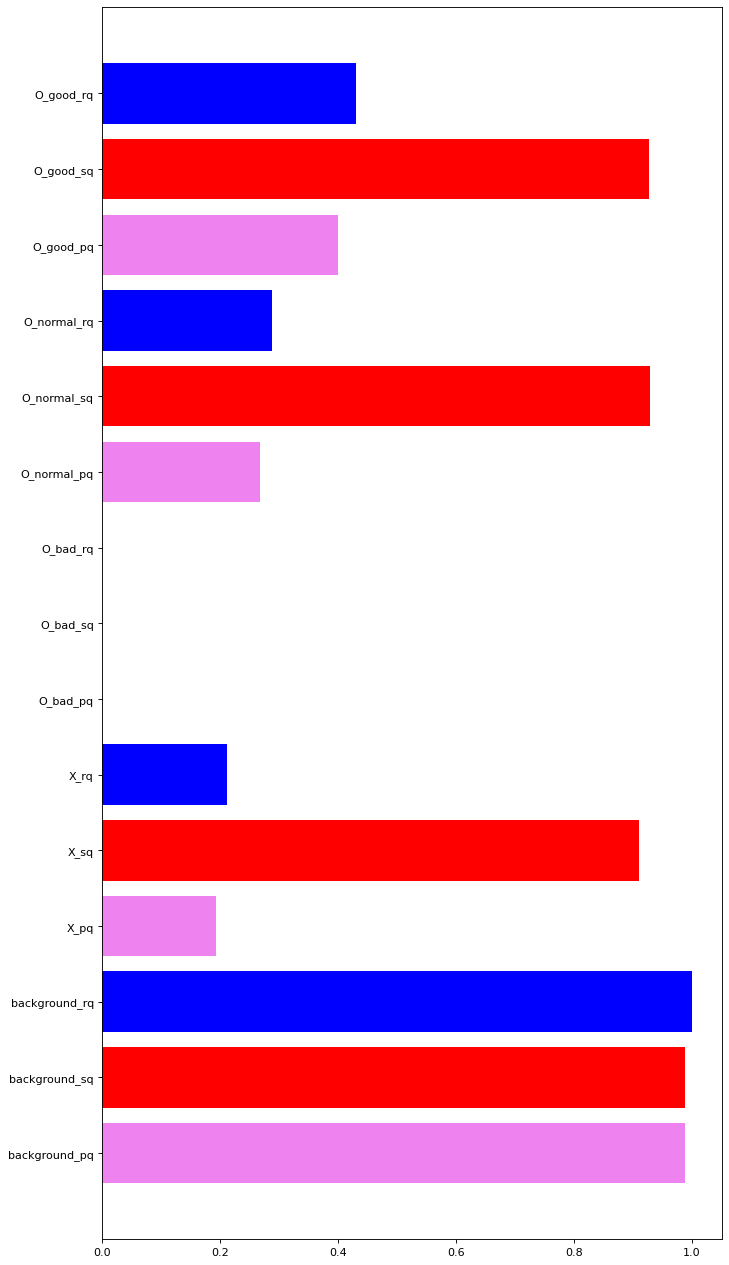

{'class_error': 58.106829135975936, 'loss': 12.366176869006868, 'loss_ce': 1.7367633976280055, 'loss_bbox': 0.06624018977534898, 'loss_giou': 0.40105653189598245, 'loss_mask': 0.007266677130865765, 'loss_dice': 0.08963120173900685, 'loss_ce_0': 1.4559797237211085, 'loss_bbox_0': 0.07379935864121356, 'loss_giou_0': 0.48327205742293217, 'loss_ce_1': 1.4981718361377716, 'loss_bbox_1': 0.06500199607553635, 'loss_giou_1': 0.4160615374591756, 'loss_ce_2': 1.5180324753151928, 'loss_bbox_2': 0.06570719749210997, 'loss_giou_2': 0.39340575467398825, 'loss_ce_3': 1.619384463242394, 'loss_bbox_3': 0.06303329395249169, 'loss_giou_3': 0.3886566330143746, 'loss_ce_4': 1.5789518862407892, 'loss_bbox_4': 0.06360732177470593, 'loss_giou_4': 0.38215323925969447, 'loss_ce_unscaled': 1.7367633976280055, 'class_error_unscaled': 58.106829135975936, 'loss_bbox_unscaled': 0.013248037918411355, 'loss_giou_unscaled': 0.20052826594799122, 'cardinality_error_unscaled': 2.297872340425532, 'loss_mask_unscaled': 0.00

In [80]:
model, criterion, postprocessors = build_pretrained_model(args)
model.to(device)

checkpoint = torch.load(checkpoint_dir+"/checkpoint.pth")

# model.load_state_dict(checkpoint['model'])
model.load_state_dict(checkpoint['model'], strict=False)

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("---")
print(f"模型的總可訓練參數量 (Total Trainable Parameters): {trainable_params:,}")

if ENABLE_WANDB:
    wandb.watch(model)

model_without_ddp = model

n_parameters = sum(p.numel() for p in model.parameters() ) #if p.requires_grad
print(f"number of params:  {n_parameters:,}")

dataset_test = build_dataset(image_set='val', args=args)

sampler_test = torch.utils.data.SequentialSampler(dataset_test)

data_loader_test = DataLoader(dataset_test, args.batch_size, sampler=sampler_test,
                                drop_last=False, collate_fn=collate_fn, num_workers=1)
print('running eval')
test_stats = evaluate(model, criterion, postprocessors,
                                        data_loader_test, device, args.output_dir)
print(test_stats)

In [ ]:
average_frame_time = 160.78992891311646 / 236
fps = 1 / average_frame_time
fps

In [ ]:
1/0.6813

# Inference

In [ ]:
# args
import random
import numpy as np
import torch

#import pdb; pdb.set_trace()

seed = 42

torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms(False)     # missing some deterministic impl

device = torch.device("cuda:0")

class Args:
    pass
args = Args()
# Postitional encoding
args.position_embedding = "sine"
# CNN Backbone
args.backbone = "resnet50"
args.dilation = None
# Hungarian matcher
args.set_cost_class = 1
args.set_cost_bbox = 5
args.set_cost_giou = 2
# Transformer
args.hidden_dim = 256
args.dropout = 0.1
args.nheads = 8
args.dim_feedforward = 2048
args.enc_layers = 6
args.dec_layers = 6
args.pre_norm = None
# DETR
args.num_queries = 100
args.aux_loss = True # calculate loss at eache decoder layer
args.masks = True
args.frozen_weights = False
args.bbox_loss_coef = 5
args.mask_loss_coef = 1
args.dice_loss_coef = 1
args.giou_loss_coef = 2
args.eos_coef = 0.1
# Dataset
args.dataset_file = "coco_panoptic" # cityscape
args.coco_path = ""
args.coco_panoptic_path = ""
# Training
args.lr = 1e-4
args.weight_decay = 0
args.lr_backbone = 0    # 0 means frozen backbone
args.batch_size = 1
args.epochs = 50
args.lr_drop = 20
args.clip_max_norm = 2

args.output_dir = "out_dir"
args.eval = False      # 使用驗證集時，eval=True
args.test = False     # 使用測試集時，eval=True, test=True

In [ ]:
# !pip install 'git+https://github.com/facebookresearch/detectron2.git'

from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import io

from detectron2.data.datasets import register_coco_panoptic
# register_coco_instances("my_dataset_train", {}, "/content/drive/MyDrive/cityscapes/gtFine/cityscapes_panoptic_train.json", "/content/drive/MyDrive/cityscapes/gtFine/cityscapes_panoptic_train")
register_coco_panoptic("my_dataset", {}, '/content/drive/MyDrive/cityscapes/leftImg8bit/val', "/content/drive/MyDrive/cityscapes/gtFine/cityscapes_panoptic_val", "/content/drive/MyDrive/cityscapes/gtFine/cityscapes_panoptic_val.json", instances_json=None)
MetadataCatalog.get("my_dataset").thing_classes = ["X", "O_bad","O_normal","O_good"]
MetadataCatalog.get("my_dataset").stuff_classes = ["bg"]
MetadataCatalog.get("my_dataset").stuff_colors = [(100,60,100)]
# MetadataCatalog.get("my_dataset").thing_colors = [(220, 20, 60),(70, 130, 180),(0,0, 70),(0, 60, 100)]
MetadataCatalog.get("my_dataset").thing_colors = [(255, 255, 0),(0, 0, 0),(0, 255, 0),(255, 0, 0)]
MetadataCatalog.get("my_dataset").stuff_dataset_id_to_contiguous_id = {2:0}
MetadataCatalog.get("my_dataset").thing_dataset_id_to_contiguous_id = {3:0,4:1,5:2,6:3}
meta = MetadataCatalog.get("my_dataset")

    # 2: (0, 0, 255),    # 背景 blue
    # 3: (255, 255, 0),    # X yellow
    # 4: (255, 0, 0),  # bad 
    # 5: (0, 255, 0),  # normal green
    # 6: (255, 0, 0),  # good red
import matplotlib.pyplot as plt
from copy import deepcopy
import gc

transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
def build_pretrained_model(args):
    pre_trained = torch.hub.load('facebookresearch/detr', 'detr_resnet50_panoptic', pretrained=True, return_postprocessor=False, num_classes=250)
    model, criterion, postprocessors = build_model(args)
    model.detr.backbone.load_state_dict(pre_trained.detr.backbone.state_dict())

    original_layer4 = list(model.detr.backbone[0].body.layer4.children())
    model.detr.backbone[0].body.layer4 = nn.Sequential(
        *original_layer4,
        MambaLayer(dim=2048),
        MambaLayer(dim=2048),
        # MambaLayer(dim=2048),
        # MambaLayer(dim=2048)

        # DSPM(in_channels=2048, out_channels=2048)
    )
    # print(model.detr.backbone)

    model.detr.bbox_embed.load_state_dict(pre_trained.detr.bbox_embed.state_dict())
    model.detr.query_embed.load_state_dict(pre_trained.detr.query_embed.state_dict())
    model.detr.input_proj.load_state_dict(pre_trained.detr.input_proj.state_dict())
    model.detr.transformer.load_state_dict(pre_trained.detr.transformer.state_dict(), strict=False)

    model.bbox_attention.load_state_dict(pre_trained.bbox_attention.state_dict())
    model.mask_head.load_state_dict(pre_trained.mask_head.state_dict())

    freeze_attn(model, args)
    return model, criterion, postprocessors

In [ ]:
# artifact_dir = '/media/tkyin/新增磁碟區/DETR/DETR/紀錄點/skip 4 stack/mamba_4stack_fold2:v38'
# fold = 'f2'

artifact_dir = '/media/tkyin/新增磁碟區/DETR/DETR/紀錄點/final/detr_mamba_dspm_noise3_fold3:v19'
fold = 'f3'

checkpoint = torch.load(artifact_dir+"/checkpoint.pth")

model, criterion, postprocessors = build_pretrained_model(args)
try:
    model.load_state_dict(checkpoint['model'])
except RuntimeError as e:
    error_message = str(e)
    # 檢查錯誤訊息中是否包含 "Unexpected key(s) in state_dict:"
    if "Unexpected key(s) in state_dict:" in error_message:
        print("檢測到 state_dict 載入錯誤。以下是所有意外的鍵：")
        # 提取錯誤訊息中關於鍵的部分
        key_part = error_message.split("Unexpected key(s) in state_dict:")[1].strip()
        # 移除前後的引號和逗號
        key_part = key_part.replace('"', '').replace(',', '')
        # 將多個鍵按逗號分割並逐行印出
        keys = [k.strip() for k in key_part.split() if k.strip()]
        for key in keys:
            print(f"- {key}")
    else:
        print(f"發生了其他的 RuntimeError:\n{error_message}")

In [ ]:
# model.load_state_dict(checkpoint['model'], strict=False)

model.eval()
model = model.to(device)

In [ ]:
image_ids =[ '1-1-1_12', '2-1-1_31', '2-1-1_35', '3-1-1_154', '3-1-1_162', '4-1-1_157', '5-1-1_0', '5-1-1_51', '5-1-1_107', '6-2-1_39', '6-2-1_44', '11-1-1_34', '11-1-1_106', '11-1-1_113', '11-1-1_161']
for image_id in image_ids:
    folder = image_id.split('_')[0]
    im = Image.open(f"/media/tkyin/新增磁碟區/DETR/DETR/get_pic/{folder}/{image_id}.jpg")

    img = transform(im).unsqueeze(0).to(device)  # 将输入数据移到 GPU
    with torch.no_grad():
        out = model(img)
        result = postprocessors['panoptic'](out, torch.as_tensor(img.shape[-2:]).unsqueeze(0))[0]

    # We extract the segments info and the panoptic result from DETR's prediction
    segments_info = deepcopy(result["segments_info"])
    # Panoptic predictions are stored in a special format png
    panoptic_seg = Image.open(io.BytesIO(result['png_string']))
    final_w, final_h = panoptic_seg.size
    # We convert the png into an segment id map
    panoptic_seg = np.array(panoptic_seg, dtype=np.uint8)
    panoptic_seg = torch.from_numpy(rgb2id(panoptic_seg))

    # print(meta)
    for i in range(len(segments_info)):
        c = segments_info[i]["category_id"]
        segments_info[i]["category_id"] = meta.thing_dataset_id_to_contiguous_id[c] if segments_info[i]["isthing"] else meta.stuff_dataset_id_to_contiguous_id[c]

    # Finally we visualize the prediction
    v = Visualizer(np.array(im.copy().resize((final_w, final_h)))[:, :, ::-1], meta, scale=1.0)
    v._default_font_size = 20
    v = v.draw_panoptic_seg_predictions(panoptic_seg, segments_info, area_threshold=0)
    plt.imshow(v.get_image())
    plt.axis('off')  # 不显示坐标轴
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    plt.savefig(f'./pred/{image_id}_{fold}.png', bbox_inches='tight', pad_inches=0)

    # 清除 matplotlib 图形对象
    plt.close('all') # 关闭所有图窗，释放matplotlib占用的内存

    # 删除不再使用的变量，并强制Python的垃圾回收
    del im, img, out, result, segments_info, panoptic_seg, v 
    gc.collect()

    # 清理 PyTorch 的 GPU 缓存 (非常重要！)
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

In [ ]:
stop

In [ ]:
image_id =[ '1-1-1_12', '2-1-1_31', '2-1-1_35', '3-1-1_154', '3-1-1_162', '4-1-1_157', '5-1-1_0', '5-1-1_51', '5-1-1_107', '6-2-1_39', '6-2-1_44', '11-1-1_34', '11-1-1_106', '11-1-1_113', '11-1-1_161']
folder = image_id.split('_')[0]
im = Image.open(f"/media/tkyin/新增磁碟區/DETR/DETR/jujube/fold1/leftImg8bit/train/{folder}/{image_id}.jpg")
# im

In [ ]:
#@title Inference { form-width: "25%" }
img = transform(im).unsqueeze(0).to(device)  # 将输入数据移到 GPU
model = model.to(device)
out = model(img)
result = postprocessors['panoptic'](out, torch.as_tensor(img.shape[-2:]).unsqueeze(0))[0]


In [ ]:
# mask

# import matplotlib.pyplot as plt
# scores = out["pred_logits"].softmax(-1)[..., :-1].max(-1)[0]
# # threshold the confidence
# keep = scores > 0.85

# # Plot all the remaining masks
# ncols = 5
# fig, axs = plt.subplots(ncols=ncols, nrows=math.ceil(keep.sum().item() / ncols), figsize=(18, 10))
# # print(axs)
# # print("---------------")
# for line in axs:
#     # print(line)
#     for a in line:
#         # print(a)
#         a.axis('off')
# for i, mask in enumerate(out["pred_masks"][keep]):
#     ax = axs[i // ncols, i % ncols]
#     ax.imshow(mask.detach().cpu().numpy(), cmap="cividis")
#     ax.axis('off')
# fig.tight_layout()

In [ ]:
# #seg mask
# import itertools, numpy
# import seaborn as sns
# palette = itertools.cycle(sns.color_palette())

# # The segmentation is stored in a special-format png
# panoptic_seg = Image.open(io.BytesIO(result['png_string']))
# panoptic_seg = numpy.array(panoptic_seg, dtype=numpy.uint8).copy()
# # We retrieve the ids corresponding to each mask
# panoptic_seg_id = rgb2id(panoptic_seg)

# # Finally we color each mask individually
# panoptic_seg[:, :, :] = 0
# for id in range(panoptic_seg_id.max() + 1):
#   panoptic_seg[panoptic_seg_id == id] = numpy.asarray(next(palette)) * 255
# plt.figure(figsize=(15,15))
# plt.imshow(panoptic_seg)
# plt.axis('off')
# plt.show()

In [ ]:
# We extract the segments info and the panoptic result from DETR's prediction
segments_info = deepcopy(result["segments_info"])
# Panoptic predictions are stored in a special format png
panoptic_seg = Image.open(io.BytesIO(result['png_string']))
final_w, final_h = panoptic_seg.size
# We convert the png into an segment id map
panoptic_seg = np.array(panoptic_seg, dtype=np.uint8)
panoptic_seg = torch.from_numpy(rgb2id(panoptic_seg))

# print(meta)
for i in range(len(segments_info)):
    c = segments_info[i]["category_id"]
    # print(i)
    # print(c)
    segments_info[i]["category_id"] = meta.thing_dataset_id_to_contiguous_id[c] if segments_info[i]["isthing"] else meta.stuff_dataset_id_to_contiguous_id[c]

# Finally we visualize the prediction
v = Visualizer(np.array(im.copy().resize((final_w, final_h)))[:, :, ::-1], meta, scale=1.0)
v._default_font_size = 20
v = v.draw_panoptic_seg_predictions(panoptic_seg, segments_info, area_threshold=0)
plt.imshow(v.get_image())
plt.axis('off')  # 不显示坐标轴
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.savefig(f'./pred/{image_id}_{fold}.png', bbox_inches='tight', pad_inches=0)
plt.show()

In [ ]:
# fig.savefig('image_no_border.png', bbox_inches='tight', pad_inches=0)

視覺化標籤

In [ ]:
# 邊界框
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import skimage.io as io
import numpy as np
import os
import json

# 設定 COCO 標註檔案的路徑
annotation_file = '/media/tkyin/新增磁碟區/DETR/DETR/cityscapes_panoptic_all.json'
# 設定圖片的路徑
img_path = '/media/tkyin/新增磁碟區/DETR/DETR/jujube/fold1/leftImg8bit/train/6-2-1/6-2-1_39.jpg'


# 載入 COCO 標註檔案 (使用 json 讀取，而不是 COCO API)
with open(annotation_file, 'r') as f:
    coco_data = json.load(f)

# 獲取所有圖片的信息
images = coco_data['annotations']

# 選擇要視覺化的圖片的 ID
img_id = '6-2-1_39'

# 獲取圖片的信息
img_info = next((item for item in images if item["image_id"] == img_id), None)

# 載入圖片
img = io.imread(img_path)

# 獲取圖片的 segments 信息
segments_info = img_info["segments_info"]

# 顯示圖片
plt.imshow(img)

# 獲取當前 axes 對象
ax = plt.gca()

# 繪製邊界框
for segment in segments_info:
    # 獲取邊界框
    bbox = segment['bbox']
    x, y, width, height = bbox

    # 創建矩形
    rect = plt.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')

    # 將矩形添加到 axes 對象
    ax.add_patch(rect)


# 顯示圖片
plt.show()

標籤畫圖

In [ ]:
import json
import numpy as np
from PIL import Image

# 設定輸入路徑
json_path = '/media/tkyin/新增磁碟區/DETR/DETR/cityscapes_panoptic_all.json'
panoptic_mask_path = '/media/tkyin/新增磁碟區/DETR/DETR/jujube/fold1/gtFine/cityscapes_panoptic_train/5-1-1_0_panoptic.png'

# 定義 category_id 對應的顏色（你可以根據實際需要擴充）
category_colors = {
    # 1: (255, 182, 193),    # 粉紅
    2: (0, 0, 255),    # 背景 blue
    3: (255, 255, 0),    # X yellow
    4: (0, 0, 0),  # bad 
    5: (0, 255, 0),  # normal green
    6: (255, 0, 0),  # good red
    # ...
}

# 載入 JSON
with open(json_path, 'r') as f:
    data = json.load(f)

# 載入 panoptic mask（通常為 RGB 或單通道對應 id）
mask_image = Image.open(panoptic_mask_path)
mask_np = np.array(mask_image)

# 如果是 RGB，要轉成單一整數 id，例如：id = R * 256^2 + G * 256 + B
if mask_np.ndim == 3:
    mask_id = mask_np[:, :, 2] * 256 * 256 + mask_np[:, :, 1] * 256 + mask_np[:, :, 0]
else:
    mask_id = mask_np  # 如果已經是單通道（即每個 pixel 的值是 segment id）

# 建立彩色圖
default_color = (0, 0, 255) #(255, 0, 193)
height, width = mask_id.shape
colored_mask = np.full((height, width, 3), default_color, dtype=np.uint8)

# 找出這張圖對應的 annotation
image_id = '5-1-1_0'
annotation = next(a for a in data['annotations'] if a['image_id'] == image_id)

# 遍歷 segments
for segment in annotation['segments_info']:
    seg_id = segment['id']
    cat_id = segment['category_id']
    color = category_colors.get(cat_id, (0,0,0))  # 若未定義顏色則用黑色
    # print(seg_id,cat_id,color)

    # 將 mask 中對應 seg_id 的像素塗上對應 category 顏色
    colored_mask[mask_id == seg_id] = color

# 儲存上色後的結果
output_image = Image.fromarray(colored_mask)
output_image.save(f'./colored/{image_id}_colored.png')

mask疊加原圖

In [ ]:
# import matplotlib.pyplot as plt
# import skimage.io as io
# import numpy as np
# from PIL import Image

# # 構建圖片的路徑
# img_path = '/media/tkyin/新增磁碟區/DETR/DETR/jujube/fold1/leftImg8bit/train/5-1-1/5-1-1_0.jpg'
# # img_id = '6-2-1_39'
# img_id = '5-1-1_0'
# # 設定分割遮罩的路徑
# # segmentation_path =  '/media/tkyin/新增磁碟區/DETR/DETR/jujube/fold1/gtFine/cityscapes_panoptic_train/6-2-1_39_panoptic.png'
# segmentation_path =  '/media/tkyin/新增磁碟區/DETR/DETR/colored/5-1-1_0_colored.png'

# # 載入圖片
# img = io.imread(img_path)

# # 獲取當前 axes 對象
# ax = plt.gca()

# # 載入分割遮罩 (PNG 圖像)
# segmentation_mask = Image.open(segmentation_path)
# segmentation_mask = np.array(segmentation_mask)

# # 選擇顏色
# color_map = {
#     (255, 0, 193):   [255, 0, 193],         # IG 粉紅
#     (0, 0, 255):   [0, 0, 255],              # 背景 blue
#     (255, 255, 0):   [255, 255, 0],       #X yellow
#     (0, 0, 0):   [0, 0, 0],    # bad
#     (0, 255, 0):   [0, 255, 0],  # normal green
#     (255, 0, 0):   [255, 0, 0],  # good red
# }

In [ ]:
#    先建立一個和原始圖片一樣大小的全黑畫布
color_mask_display = np.zeros_like(img)

#    遍歷你的顏色映射表
for mask_rgb_tuple, display_color_list in color_map.items():
    # 找到原始遮罩中所有像素值等於 mask_rgb_tuple 的位置
    locations = np.all(segmentation_mask == mask_rgb_tuple, axis=-1)
    
    # 將這些位置在新的彩色遮罩上著色
    color_mask_display[locations] = display_color_list


# 3. 將彩色遮罩疊加到原始圖片上
alpha = 0.4  # 設定透明度 (0.0 完全透明, 1.0 完全不透明)

# 建立一個布林遮罩，標記所有不是背景色的地方 (即我們想要疊加顏色的地方)
# 這裡我們假設背景在 color_map 中被映射為 [0,0,0]
non_background_mask = np.any(color_mask_display > 0, axis=-1)

# 複製一份原始影像，以避免修改原始影像
blended_img = img.copy()

# 只在非背景區域進行 alpha 混合
# 公式: blended = img * (1 - alpha) + overlay * alpha
blended_img[non_background_mask] = (
    (img[non_background_mask] * (1 - alpha)) + 
    (color_mask_display[non_background_mask] * alpha)
).astype(np.uint8)


# blended_img 是 numpy array，shape = (H, W, 3)
output_img = Image.fromarray(blended_img)
target_size=(640, 360)
output_img = output_img.resize(target_size, resample=Image.BILINEAR)
output_img.save(f"./labeled/{img_id}_labeled.png")

# --- 顯示結果 ---
plt.imshow(blended_img)
plt.axis('off')
plt.show()

In [ ]:
# from PIL import Image
# import numpy as np
# from collections import Counter

# def analyze_segmentation_mask(image_path):
#     """
#     分析分割遮罩圖片，計算每種顏色的像素數量和百分比。

#     Args:
#         image_path (str): 圖片檔案的路徑。
#     """
#     try:
#         # 打開圖片
#         # 使用 .convert('RGB') 是為了確保圖片是標準的RGB格式
#         # 分割遮罩有時會是 'P' (調色盤) 模式，轉換後才能正確讀取顏色
#         img = Image.open(image_path).convert('RGB')
        
#         # 將圖片轉換為 NumPy 陣列，方便進行數學運算
#         np_array = np.array(img)
        
#         # 獲取圖片的寬度和高度
#         h, w, _ = np_array.shape
#         total_pixels = h * w
        
#         # 將 3D 陣列 (height, width, channels) 轉換為 2D 陣列 (num_pixels, channels)
#         # 這樣每一行就是一個像素的 (R, G, B) 值
#         pixels = np_array.reshape(-1, 3)
        
#         # 將 NumPy 陣列中的每一行轉換為元組，以便 Counter 可以計數
#         # 因為 list 不能作為字典的 key，但 tuple 可以
#         pixel_tuples = [tuple(p) for p in pixels]
        
#         # 使用 collections.Counter 來高效地計算每種顏色的數量
#         color_counts = Counter(pixel_tuples)
        
#         print(f"圖片路徑: {image_path}")
#         print(f"總像素數: {total_pixels}")
#         print("-" * 30)
#         print("顏色分析結果：")
        
#         # 按照像素數量從多到少排序並輸出結果
#         for color, count in color_counts.most_common():
#             percentage = (count / total_pixels) * 100
#             print(f"顏色 (R,G,B): {color} | 像素數量: {count:<8} | 佔比: {percentage:.2f}%")
            
#     except FileNotFoundError:
#         print(f"錯誤：找不到檔案 '{image_path}'")
#     except Exception as e:
#         print(f"處理圖片時發生錯誤: {e}")

# # --- 使用範例 ---
# # 將 'your_mask.png' 換成你自己的分割遮罩檔案路徑
# mask_file = '/media/tkyin/新增磁碟區/DETR/DETR/jujube/fold1/gtFine/cityscapes_panoptic_train/6-2-1_19_panoptic.png' 
# analyze_segmentation_mask(mask_file)
